In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [3]:
from matplotlib.patheffects import withStroke

In [4]:
# Information for TIGRESS synthetic maps
# dust polarization maps at 353 GHz can be downloaded at https://lambda.gsfc.nasa.gov/simulation/tb_tigress_data.cfm
data_folder = '../data/allsky_maps/'

# 9 observer positions
observers = ['x0y0z0','x-256y0z0','x256y0z0',
             'x0y-256z0','x-256y-256z0','x256y-256z0',
             'x0y256z0','x-256y256z0','x256y256z0']

# 350 snapshots to process
itimes=np.arange(300,650,dtype=int)

In [5]:
# pandas and xarray are used to handle data
import pandas as pd
import xarray as xr
# seaborn is used for plotting
import seaborn as sns

In [8]:
# for b>30
bcut = 'b30.N'
with xr.open_dataset('../data/all_cls.b30.rebin.N.nc') as dset:
    avg_l35=dset.sel(leff=34.0,method='nearest')
    avg_l80=dset.sel(leff=79.5,method='nearest')
    avg_l200=dset.sel(leff=199.5,method='nearest')

Ndflist = []
for avg in [avg_l35,avg_l80,avg_l200]:
    ratio=xr.Dataset()
    ratio['EEBB'] = avg['EE']/avg['BB']
    ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
    ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
    ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

    # convert to pandas dataframe to use seaborn pairplot
    dlist=[]
    for i,obs in enumerate(observers):
        df = ratio.sel(observer=i).to_array().to_pandas()
        ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
        dlist.append(df.append(ob).T)

    df=pd.concat(dlist,ignore_index=True)
    Ndflist.append(df)
    
# for b<30
bcut = 'b30.S'
with xr.open_dataset('../data/all_cls.b30.rebin.S.nc') as dset:
    avg_l35=dset.sel(leff=34.0,method='nearest')
    avg_l80=dset.sel(leff=79.5,method='nearest')
    avg_l200=dset.sel(leff=199.5,method='nearest')

Sdflist = []
for avg in [avg_l35,avg_l80,avg_l200]:
    ratio=xr.Dataset()
    ratio['EEBB'] = avg['EE']/avg['BB']
    ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
    ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
    ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

    # convert to pandas dataframe to use seaborn pairplot
    dlist=[]
    for i,obs in enumerate(observers):
        df = ratio.sel(observer=i).to_array().to_pandas()
        ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
        dlist.append(df.append(ob).T)

    df=pd.concat(dlist,ignore_index=True)
    Sdflist.append(df)

# distribution from all maps with Spearman's correlation coefficient

In [9]:
labels_dict = dict(EEBB=r'$EE/BB$', rTE=r'$r^{TE}$', rTB=r'$r^{TB}$', rEB=r'$r^{EB}$',)
def pair_plot_with_corr(df_selected, labels = [r'$EE/BB$',r'$r^{TE}$',r'$r^{TB}$',r'$r^{EB}$'], corr_method='spearman'):
    g = sns.PairGrid(df_selected,diag_sharey=False,corner=True)
    g.map_lower(sns.scatterplot, s=15)
    g.map_diag(sns.distplot,kde=False)

    if labels is not None:
        for ax,lab in zip(g.axes[1:,0],labels[1:]):
            ax.set_ylabel(lab)
        for ax,lab in zip(g.axes[-1,:],labels[:]):
            ax.set_xlabel(lab)
        
    corr = df_selected.corr(method=corr_method)
    for i,xv in enumerate(g.x_vars):
        for j,yv in enumerate(g.y_vars[i+1:]):
            plt.sca(g.axes[j+i+1,i])
            plt.annotate(r'$\rho = {:.2f}$'.format(corr[xv][yv]),(0.95,0.05),
                         ha='right',va='bottom',xycoords='axes fraction',
                         path_effects=[withStroke(foreground='w',linewidth=3)]
                        )
            print(xv,yv,corr[xv][yv])
        plt.sca(g.axes[i,i])
        q=df_selected[xv].quantile([0.16,0.5,0.84])
        dql=(q[0.16]-q[0.5])
        dqu=(q[0.84]-q[0.5])
        plt.title(labels_dict[xv]+r'$ = {:.2f}^{{{:.2f}}}_{{{:.2f}}}$'.format(q[0.5],dqu,dql))
    for i,xv in enumerate(g.x_vars):
        plt.sca(g.axes[-1,i])
        if (xv == 'EEBB'): plt.xlim(0,3)
        elif (xv == 'rTE'): plt.xlim(-0.55,0.55)
        elif (xv == 'rTB'): plt.xlim(-0.55,0.55)
        elif (xv == 'rEB'): plt.xlim(-0.55,0.55)
    for i,yv in enumerate(g.y_vars[1:]):
        plt.sca(g.axes[i+1,0])
        if (yv == 'EEBB'): plt.ylim(0,3)
        elif (yv == 'rTE'): plt.ylim(-0.55,0.55)
        elif (yv == 'rTB'): plt.ylim(-0.55,0.55)
        elif (yv == 'rEB'): plt.ylim(-0.55,0.55)
    return g

EEBB rTE 0.3647481706065416
EEBB rTB 0.051510930865299155
EEBB rEB -0.027156133032328132
rTE rTB -0.046088993355019786
rTE rEB -0.09390473815882375
rTB rEB 0.25851937750378257
EEBB rTE 0.5520223274782847
EEBB rTB 0.08106122018157685
EEBB rEB -0.00416635077802189
rTE rTB -0.06254799185836821
rTE rEB -0.09986788456838391
rTB rEB 0.3465162531372485
EEBB rTE 0.5525083770779537
EEBB rTB 0.07574523985002837
EEBB rEB 0.06980997696917547
rTE rTB -0.06270461369325073
rTE rEB -0.09192144515399273
rTB rEB 0.39595038248789083
EEBB rTE 0.39071711288706223
EEBB rTB -0.08986328122534838
EEBB rEB -0.031047340181617745
rTE rTB -0.020020819927952193
rTE rEB 0.05029947952003777
rTB rEB 0.28351338681342847
EEBB rTE 0.6134693572465488
EEBB rTB -0.09886471101589188
EEBB rEB -0.005876286762418371
rTE rTB -0.006547235635661848
rTE rEB 0.08008066765861148
rTB rEB 0.31240837653997483
EEBB rTE 0.6321327435951847
EEBB rTB -0.08758864456375738
EEBB rEB 0.005276141481236589
rTE rTB -0.038951053032296075
rTE rEB 0.0

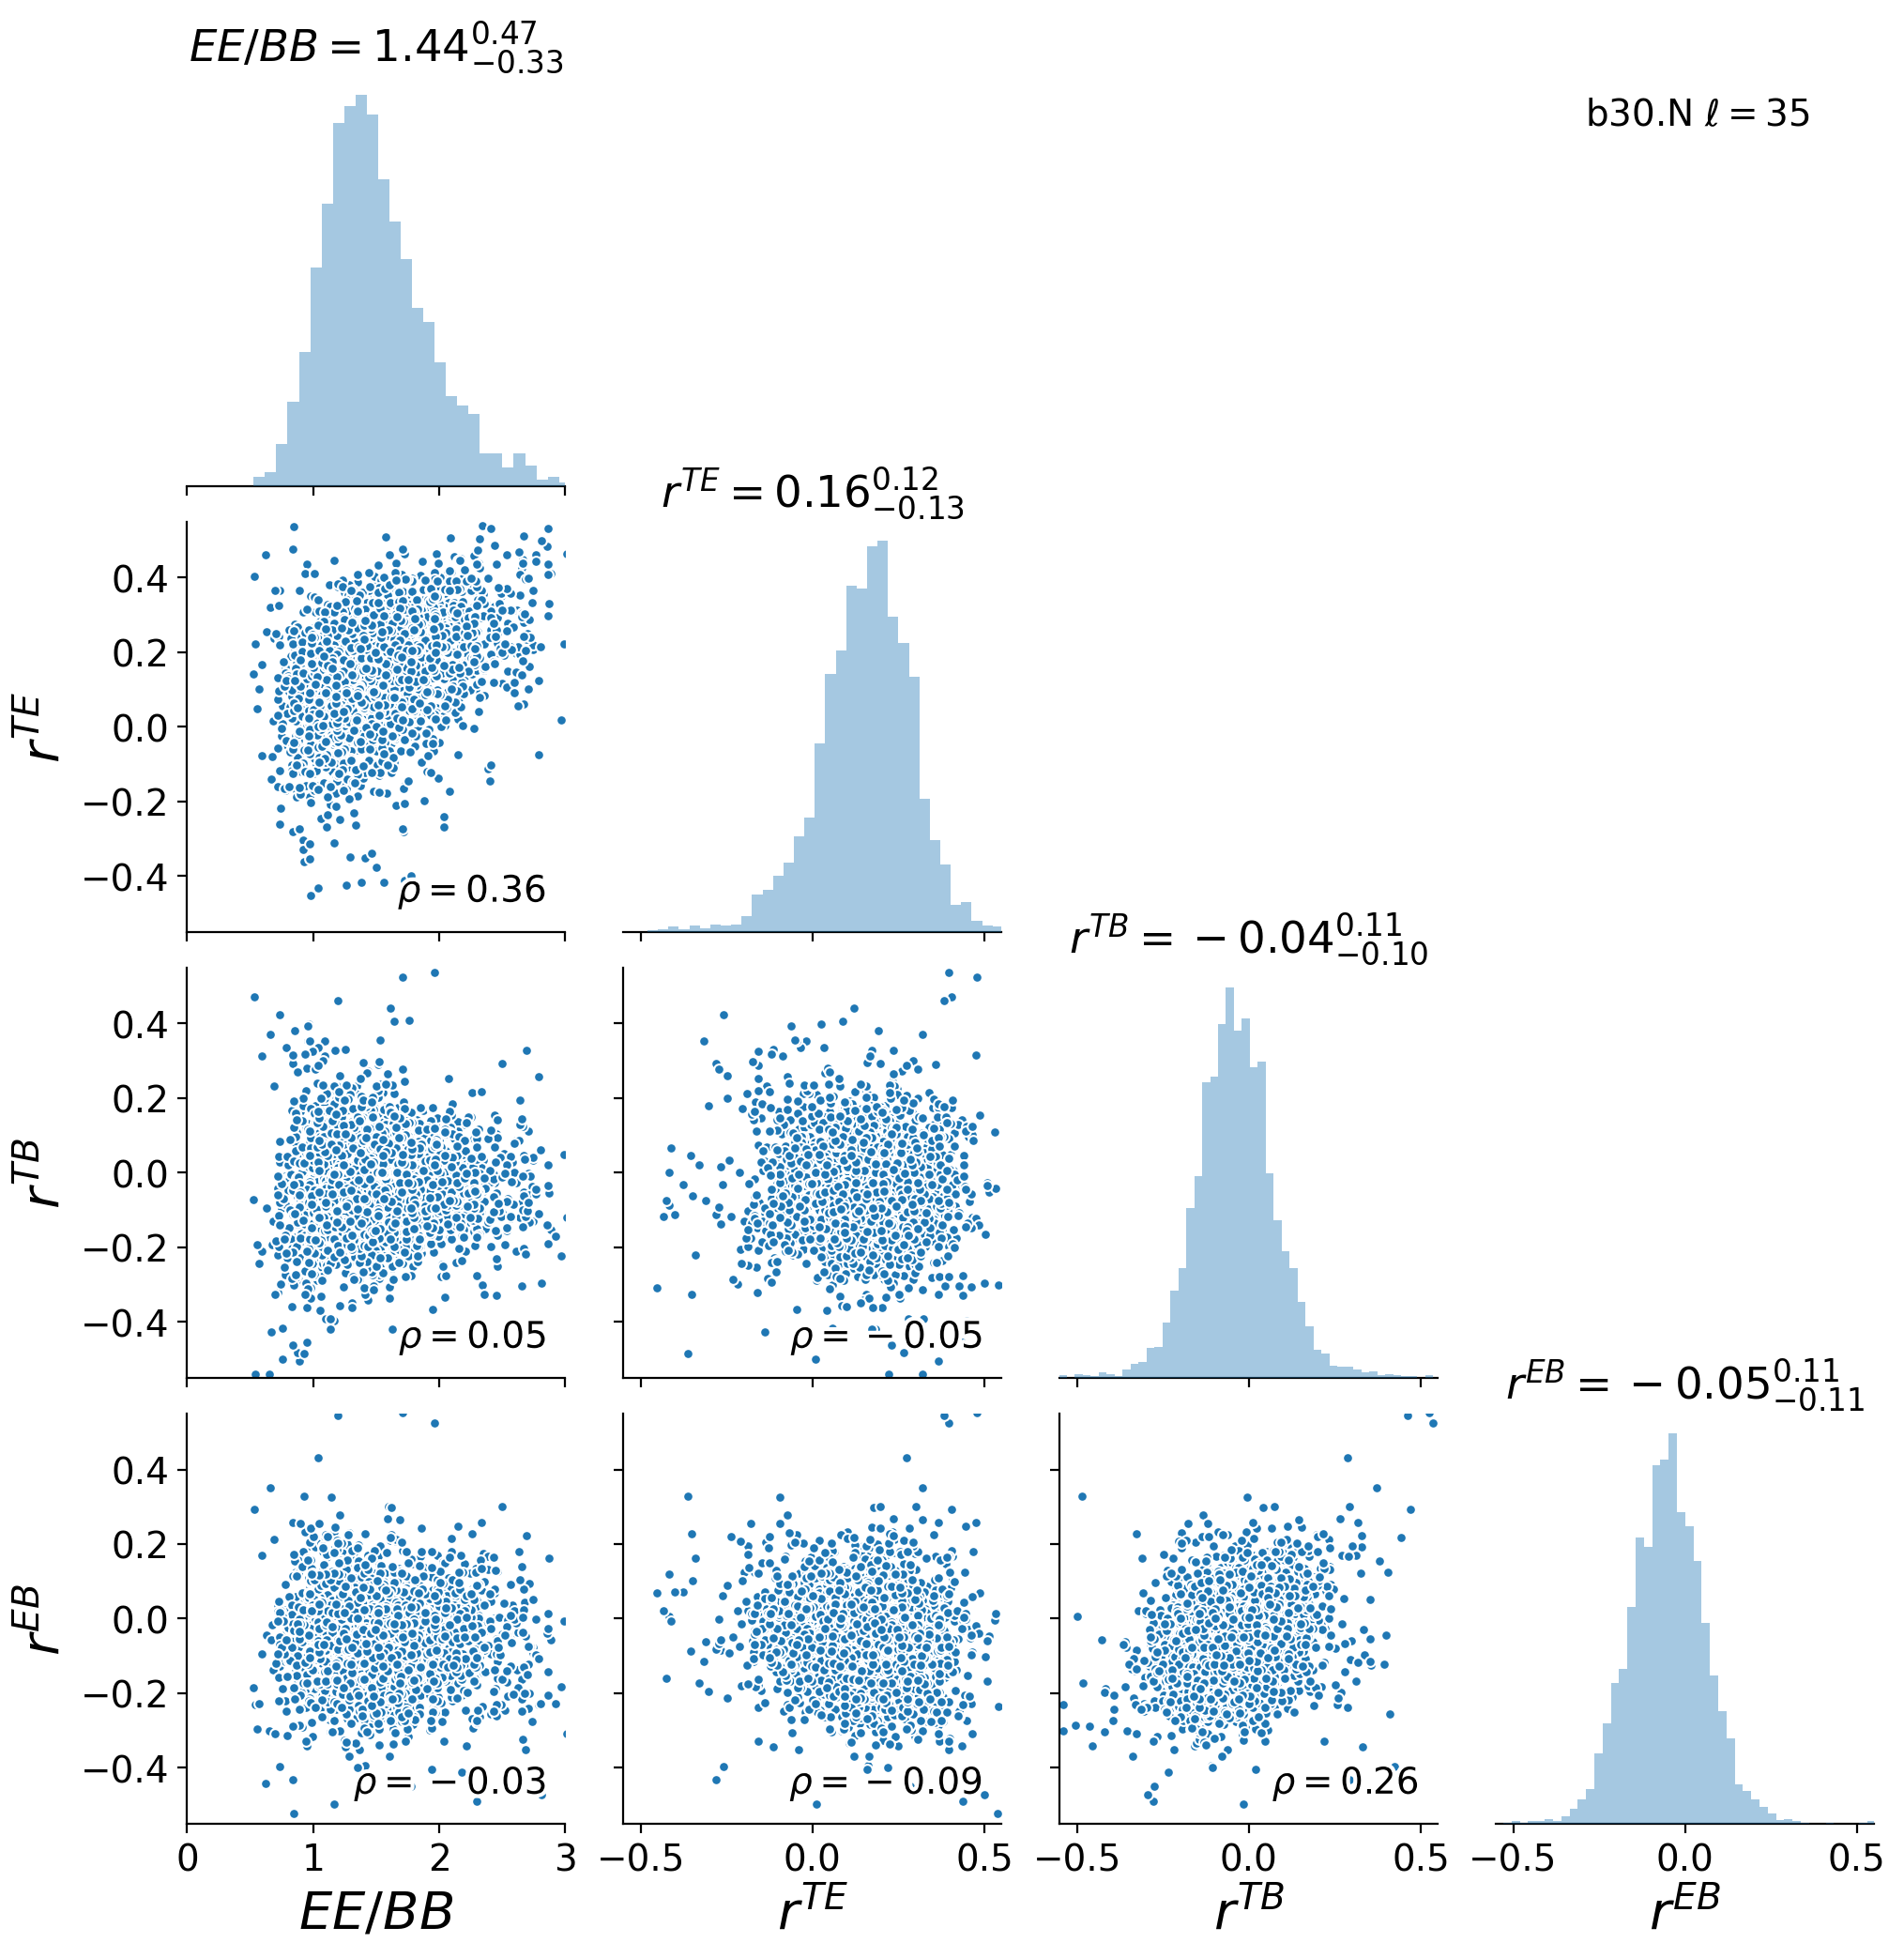

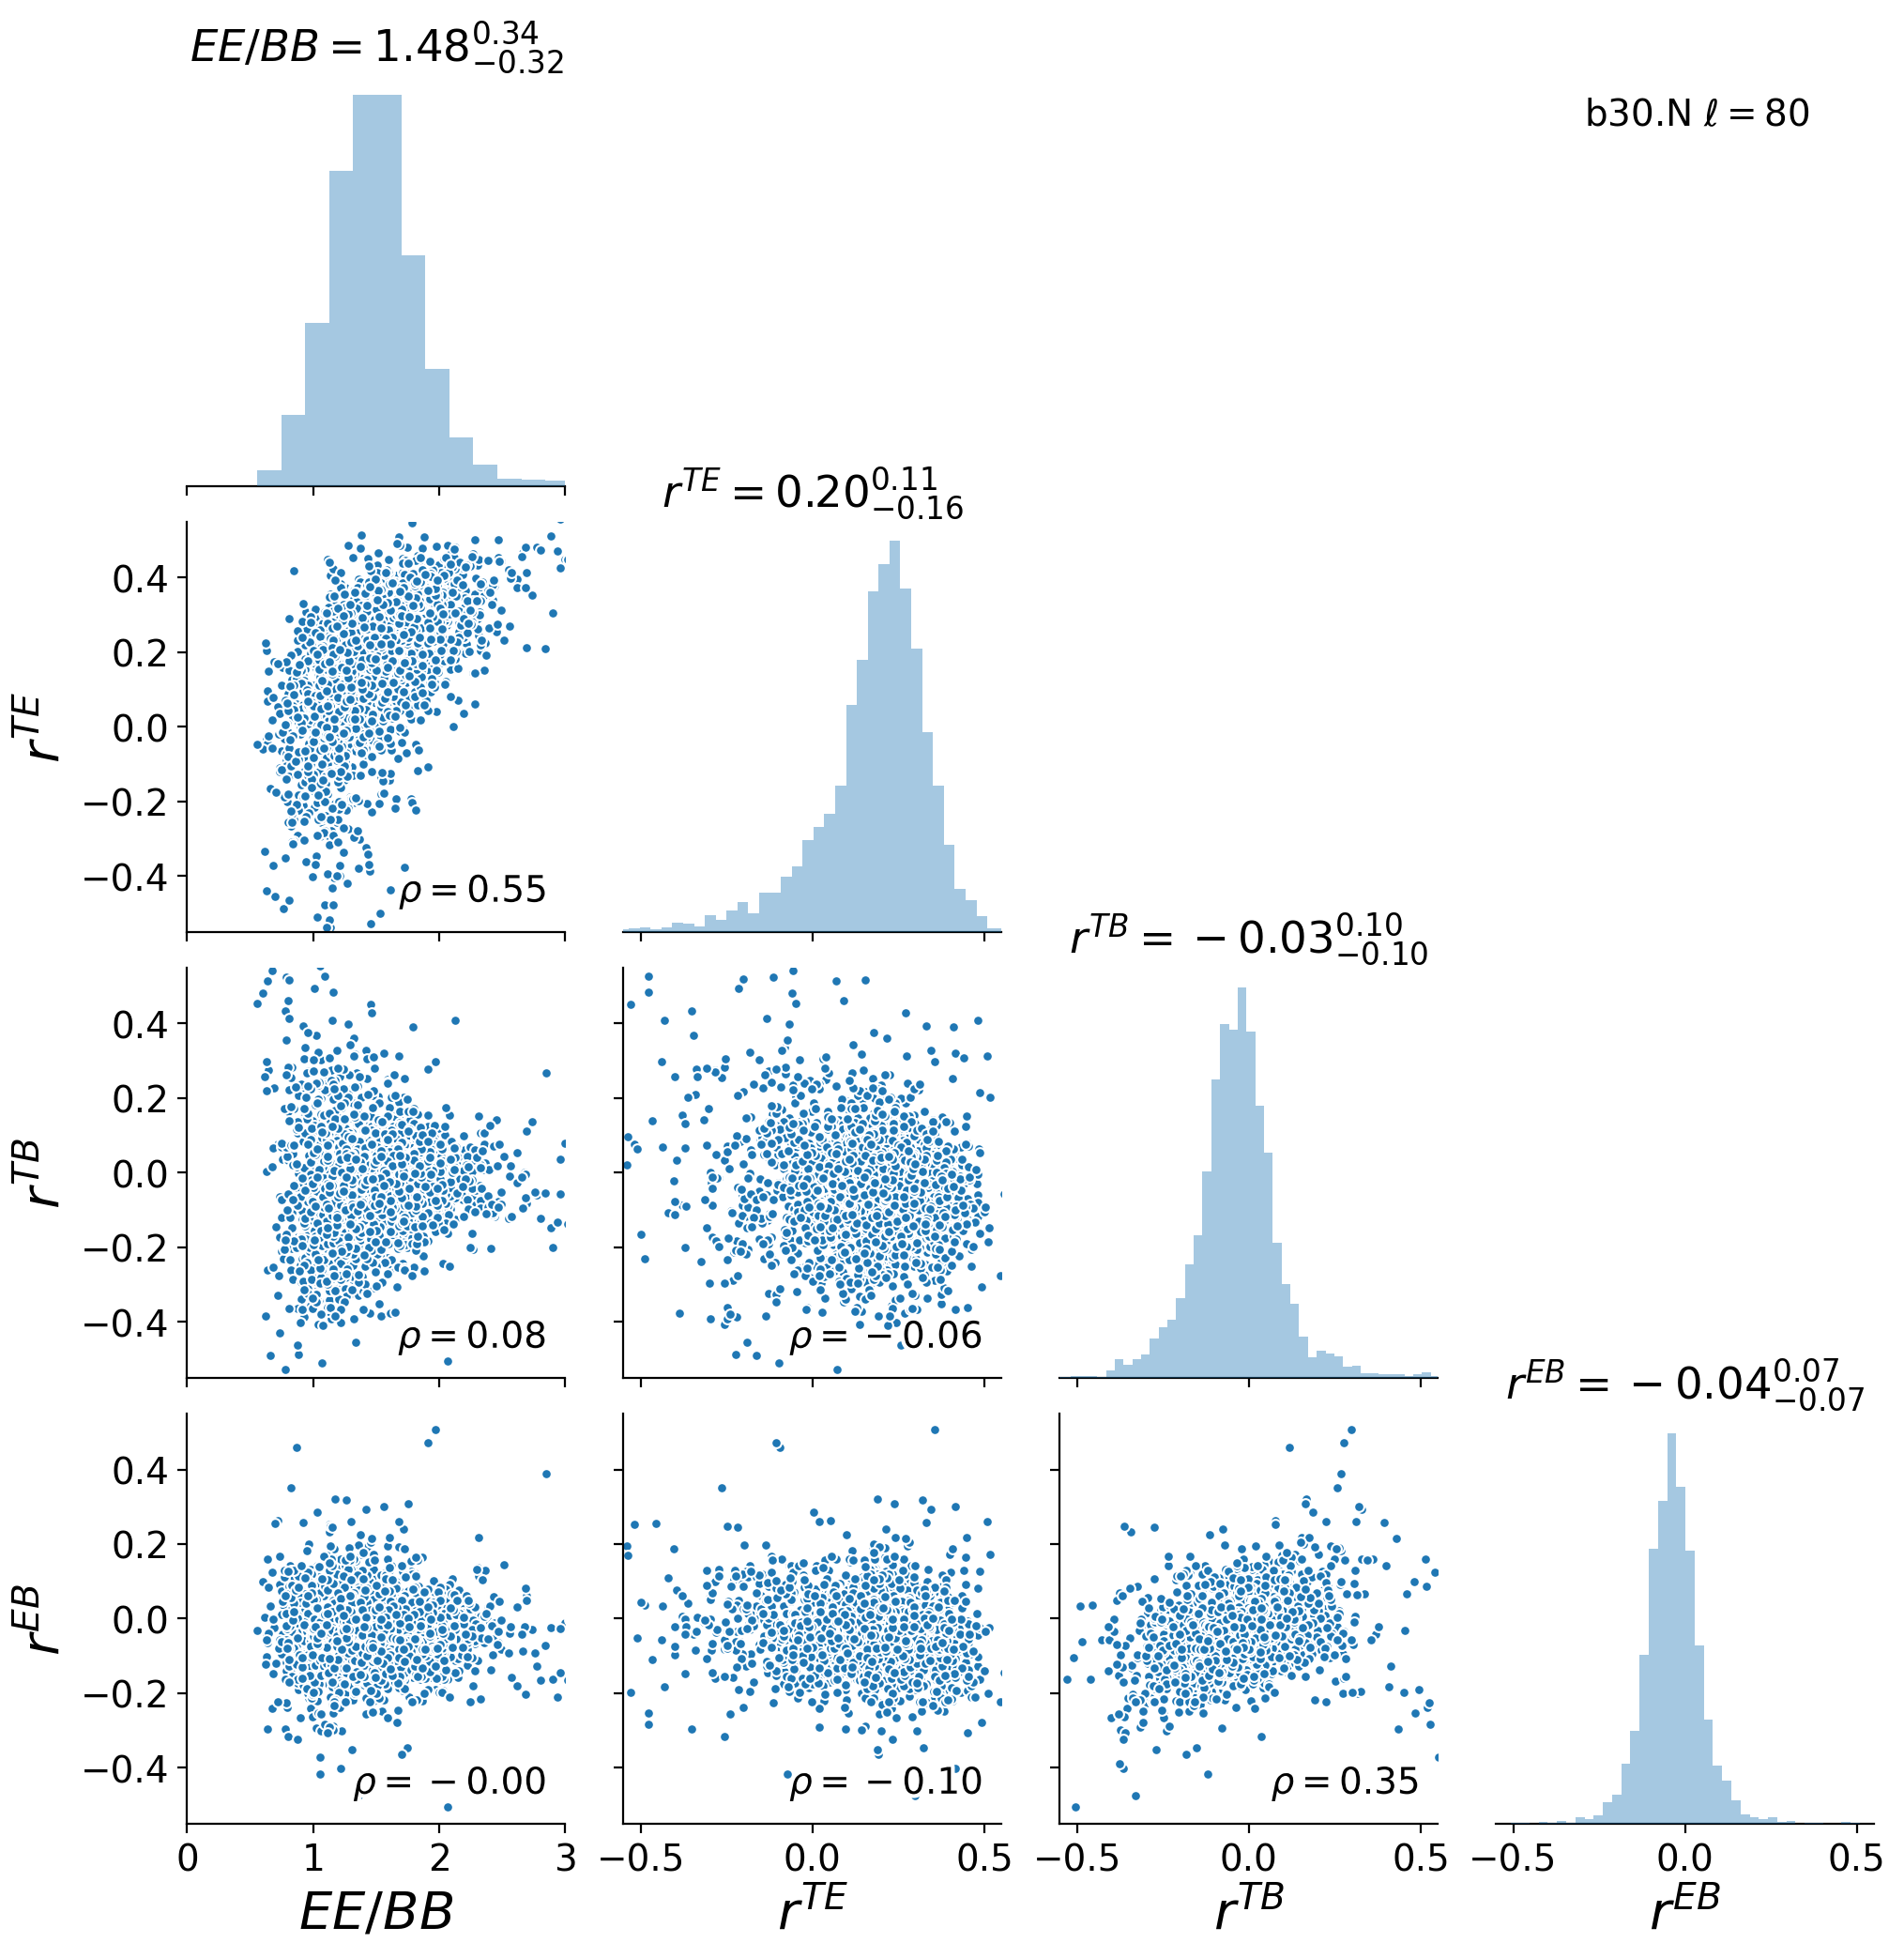

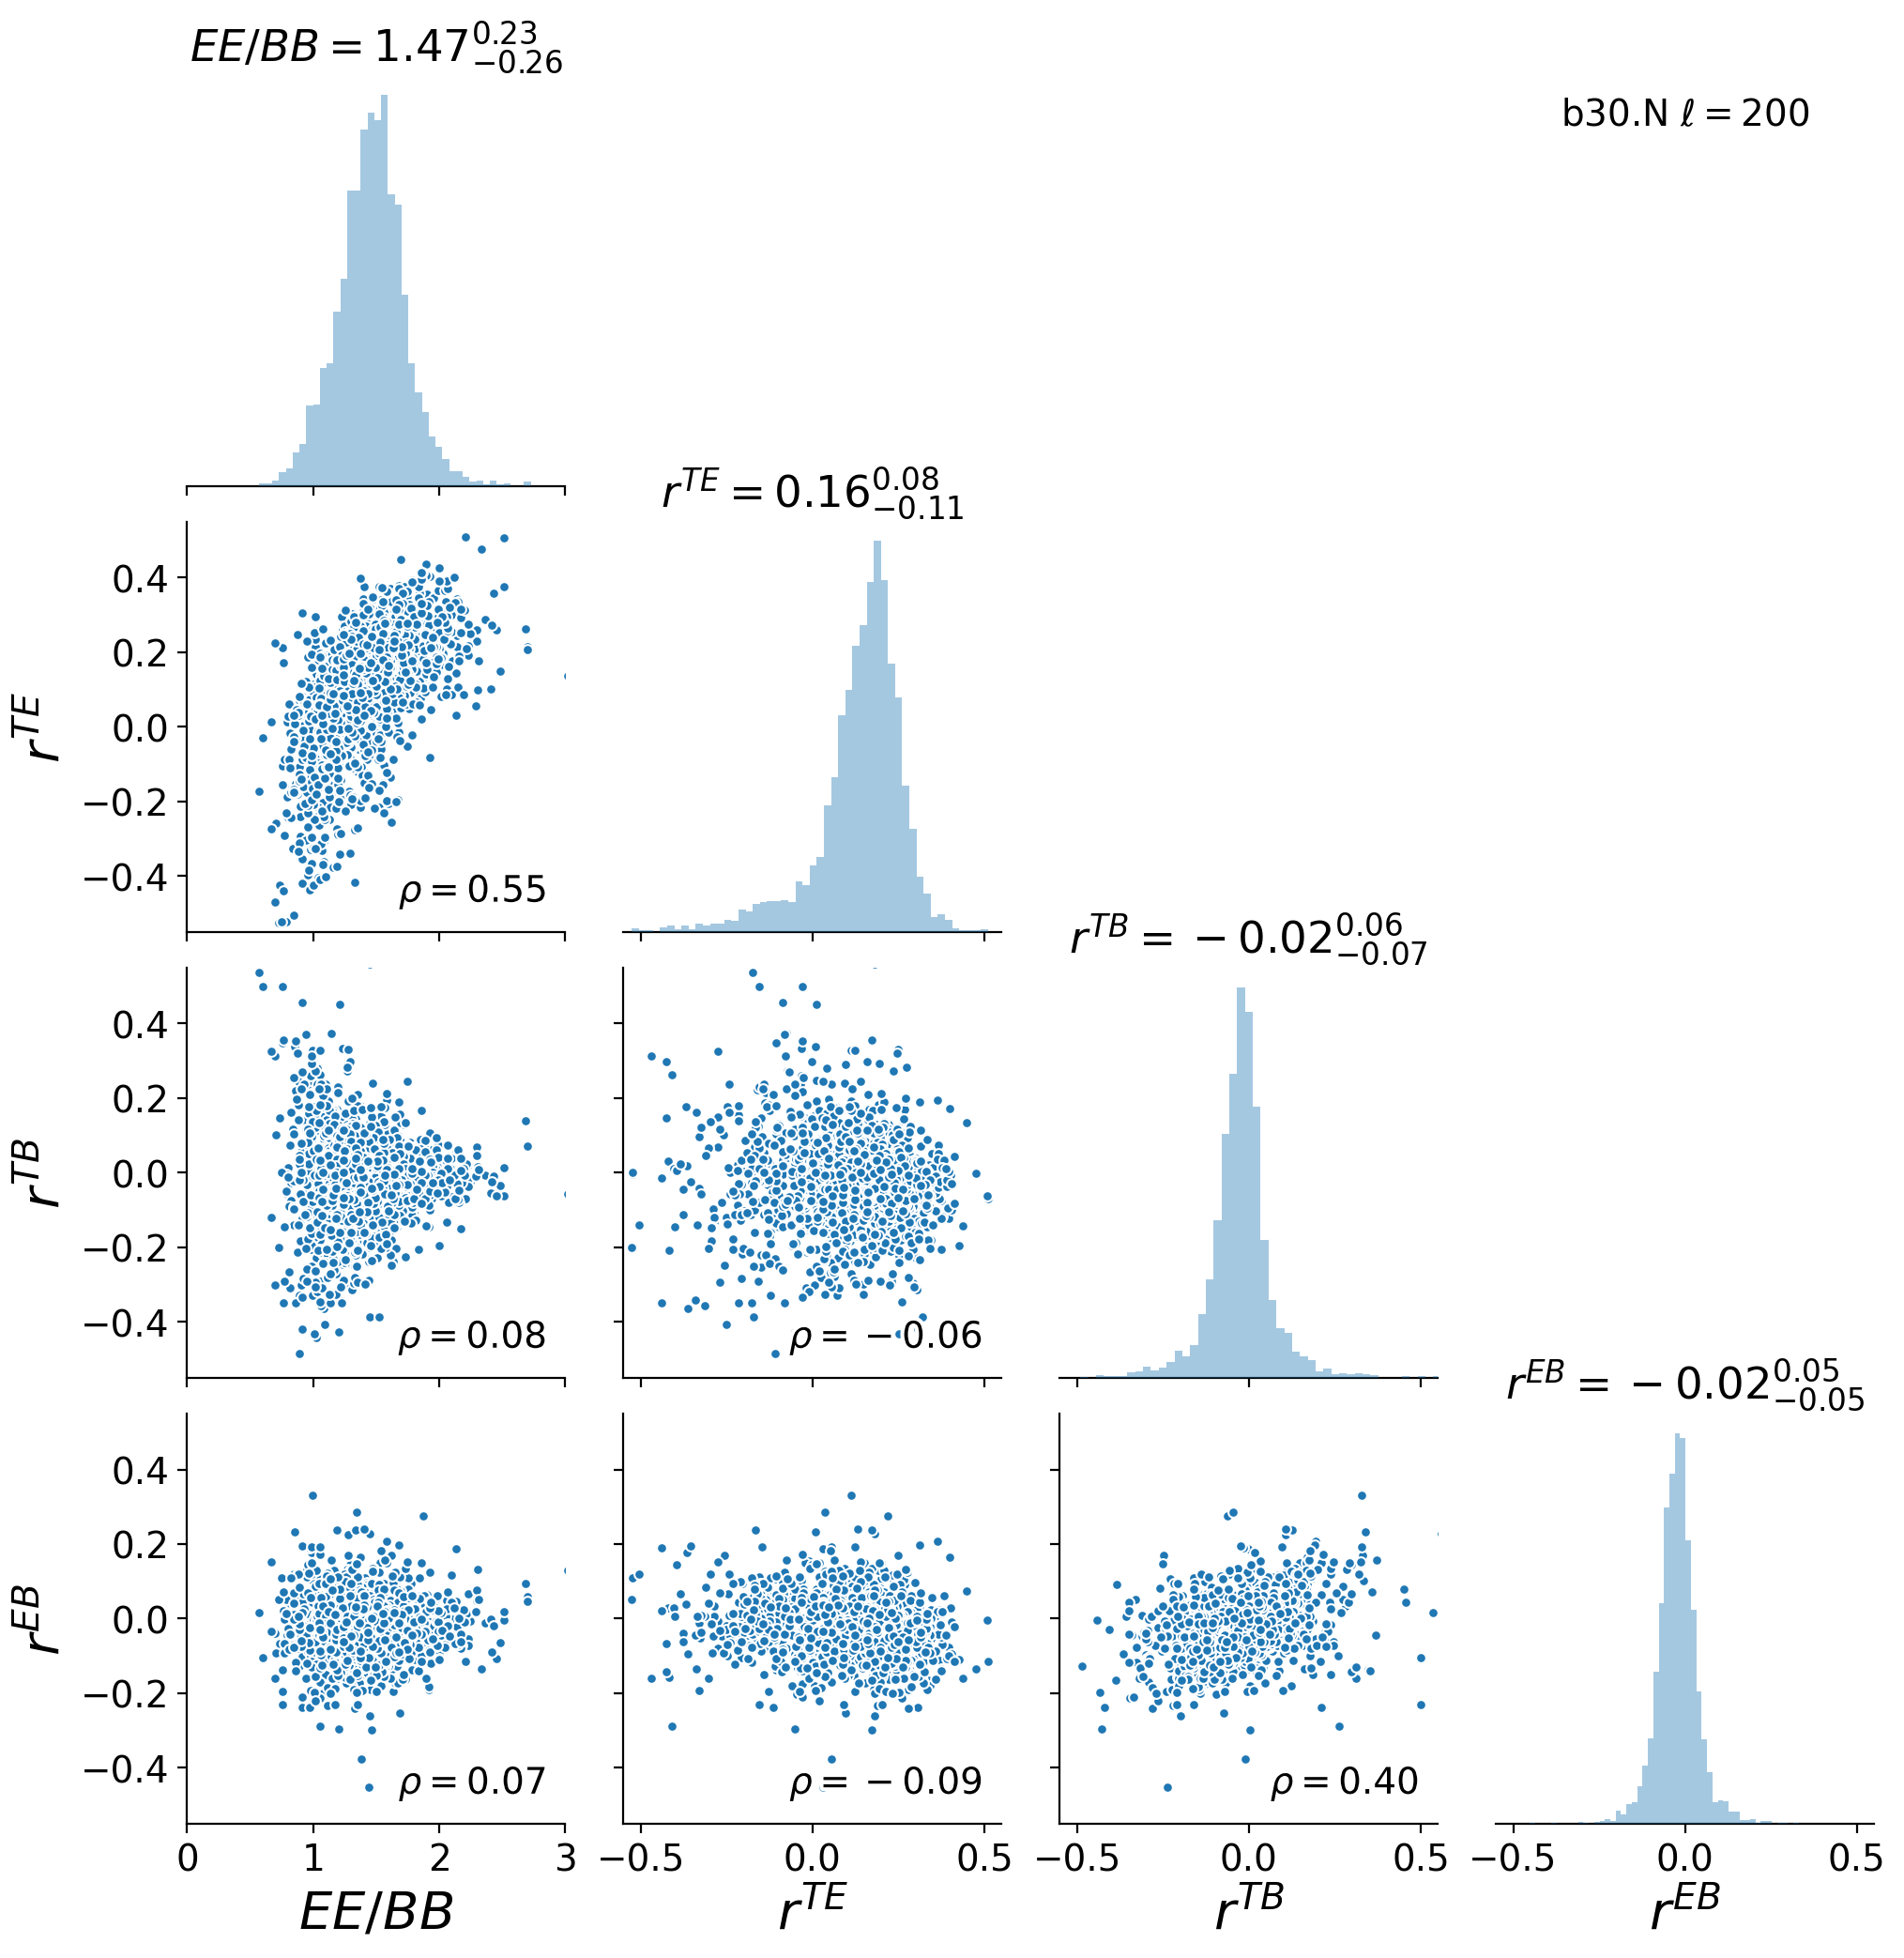

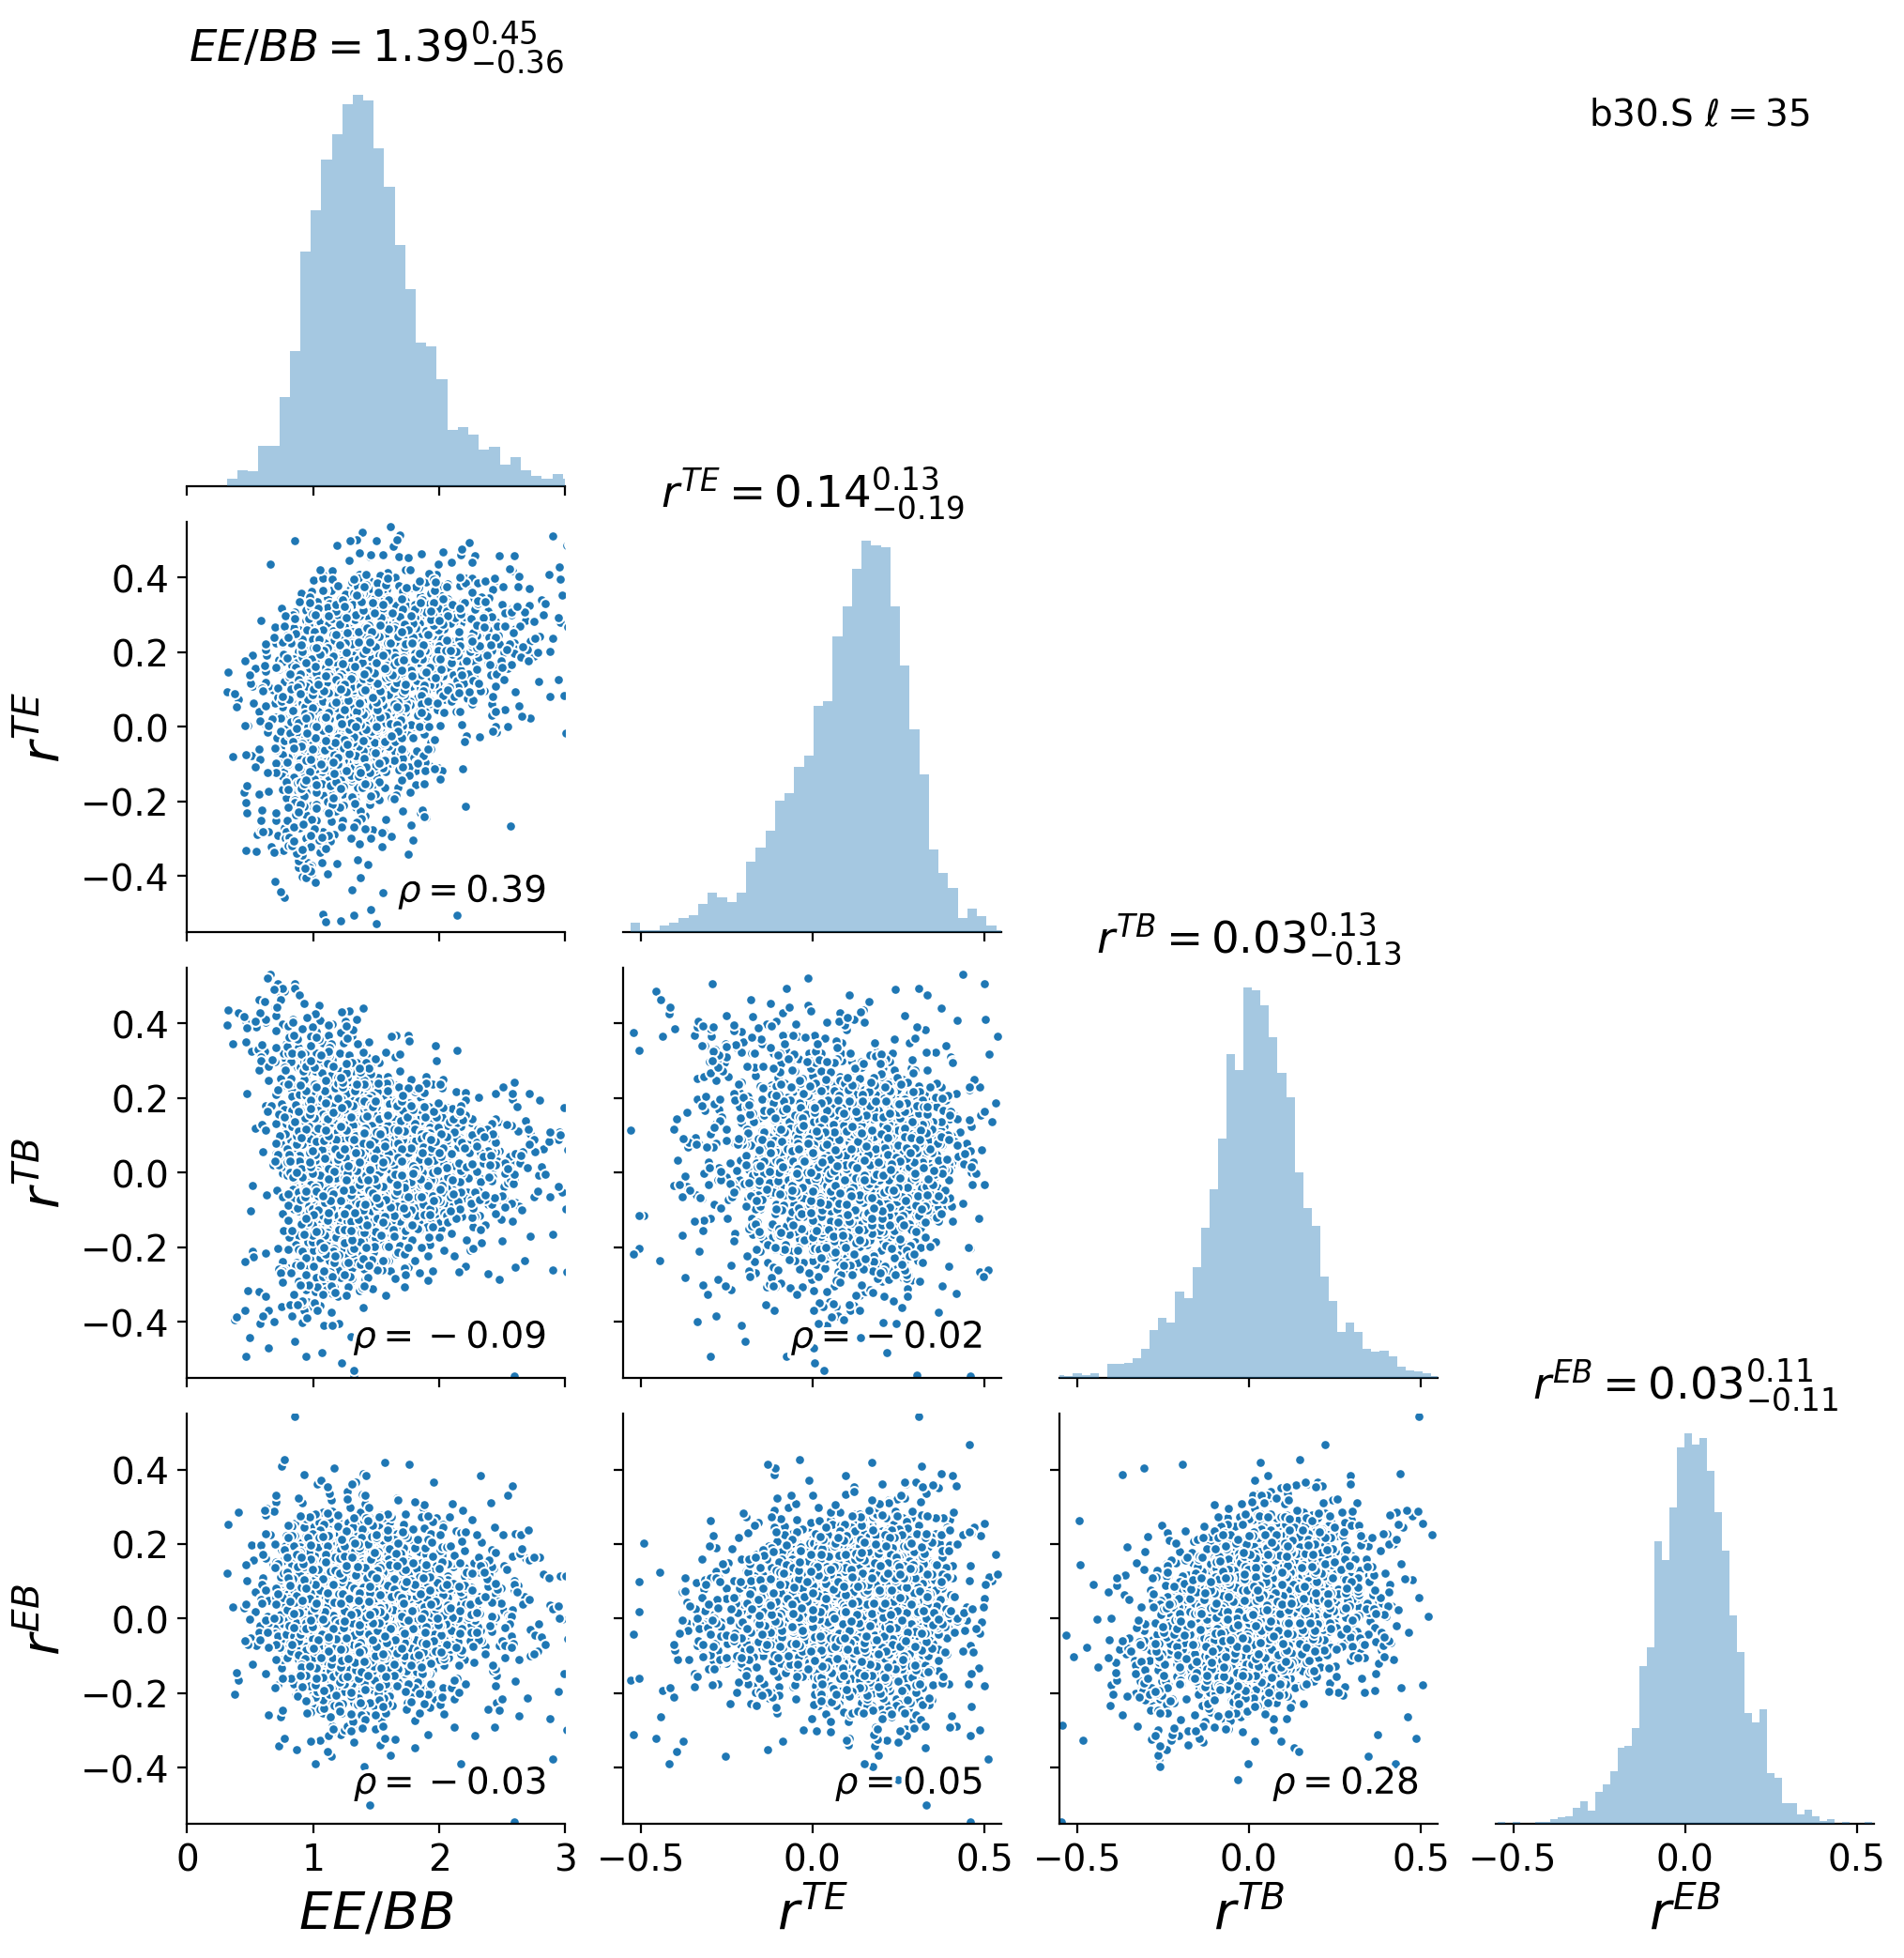

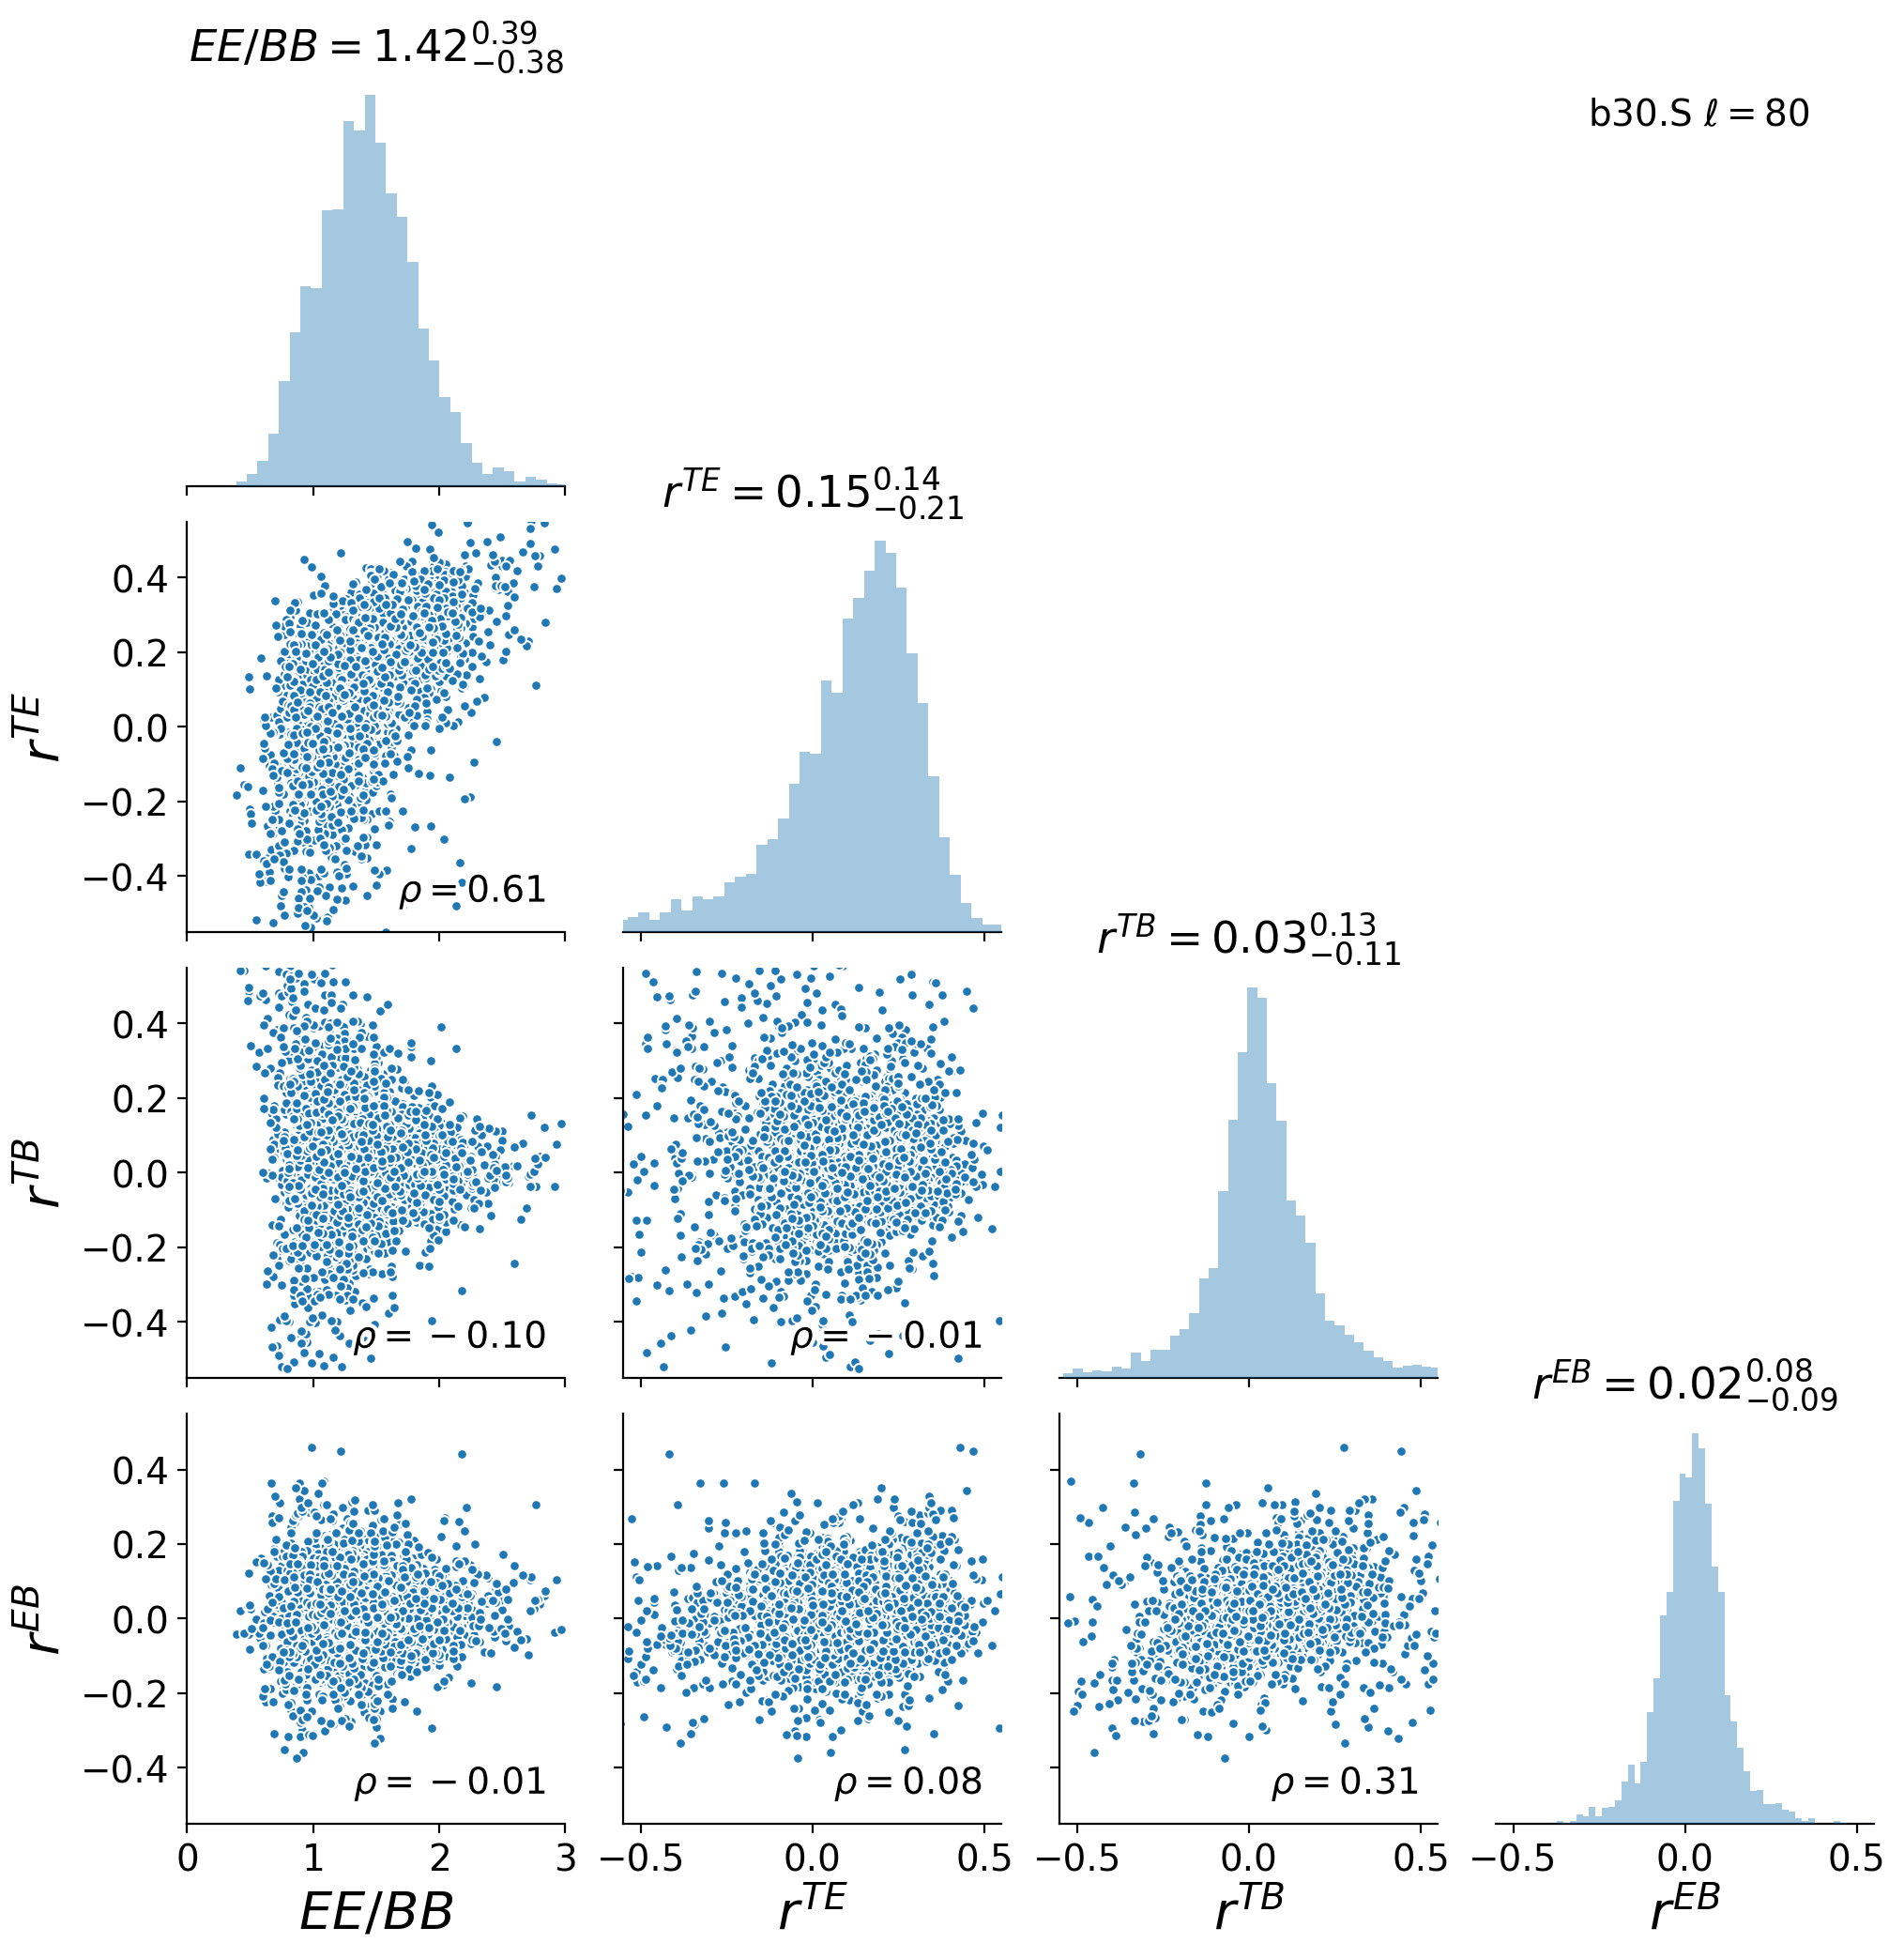

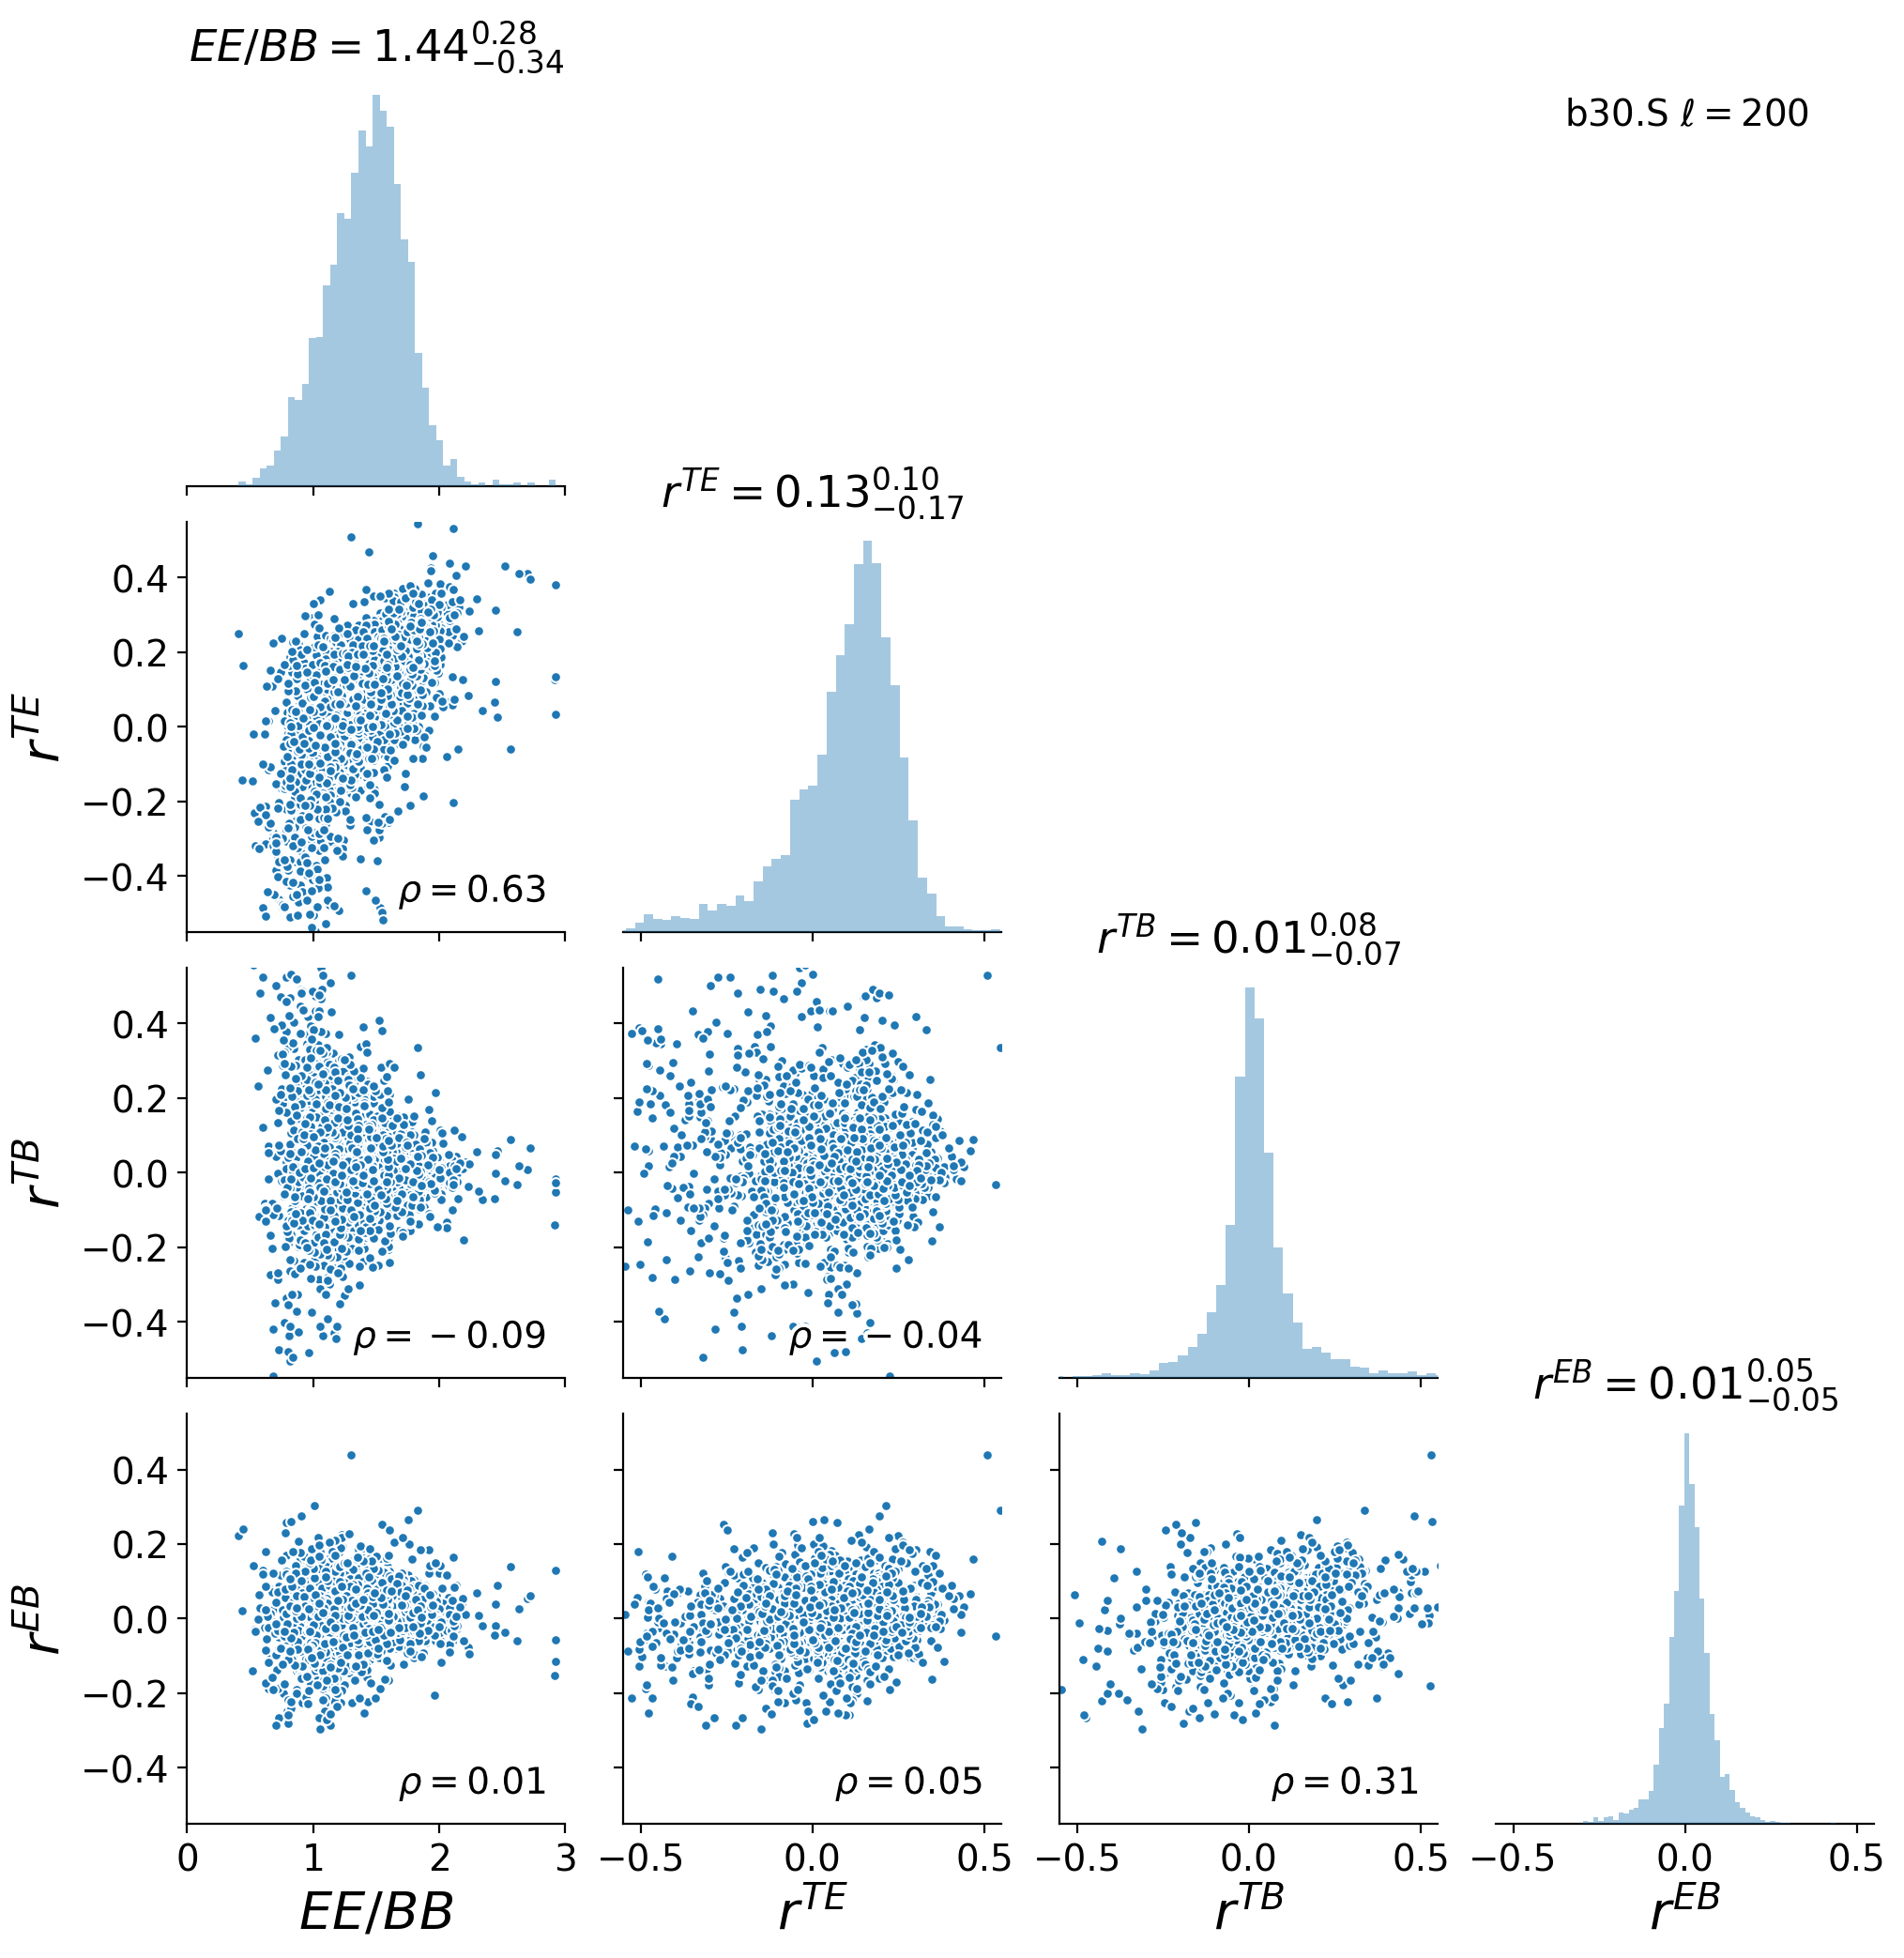

In [14]:
with plt.style.context({'figure.dpi':200,'font.size':14,'axes.labelsize':'x-large'}):
    corr_method='spearman'
    for dflist,bcut in zip([Ndflist,Sdflist],['b30.N','b30.S']):
        for df,lc in zip(dflist,['l35','l80','l200']):
            df_selected = df[['EEBB','rTE','rTB','rEB']]
            g = pair_plot_with_corr(df_selected,corr_method=corr_method)
            plt.annotate(r'{} $\ell=${}'.format(bcut,lc[1:]),(.95,0.95),xycoords='figure fraction',ha='right',va='top')
            g.savefig('../figures/all_corr_{}_{}_{}.png'.format(corr_method,bcut,lc),bbox_inches='tight',dpi=200)

# Correlations in maps with strong TE or TB

rEB rTB 0.6020979509176827 -0.006116566683015551
rTB rEB 0.5624232115399193 -0.03788870955502004
rEB rTB -0.9536165460248613 -0.03580859781267662
rTB rEB -0.5377331498162088 -0.03177526903783382
rEB rTE 0.7320497828797158 0.045193536161525806
rTE rEB 0.7188464392542935 -0.01596586277680303
rEB rTE -0.8126534111842398 0.06274348457070783
rTE rEB -0.5370135431202353 -0.03123581847783033
rEB rTB 0.8047986163212697 -0.007790960117168011
rTB rEB 0.5617394510787989 -0.01858180320577534
rEB rTB -0.7608276166769051 -0.005888614681163405
rTB rEB -0.22636505097609955 -0.00782813835040597
rEB rTE 0.9467971611459114 -0.023814101896653554
rTE rEB 0.4168447467027281 0.03210895037587408
rEB rTE -0.9771459419922601 0.03049830679300361
rTE rEB -0.378216927725992 -0.053505813457924184
rEB rTB 0.9673396519462142 -0.0033279839886492767
rTB rEB 0.5047575192203568 -0.013233563566597606
rEB rTB -0.206367137879521 -0.04035213227911896
rTB rEB -0.060720945960358694 -0.009413414905944457
rEB rTE 0.7277936615663

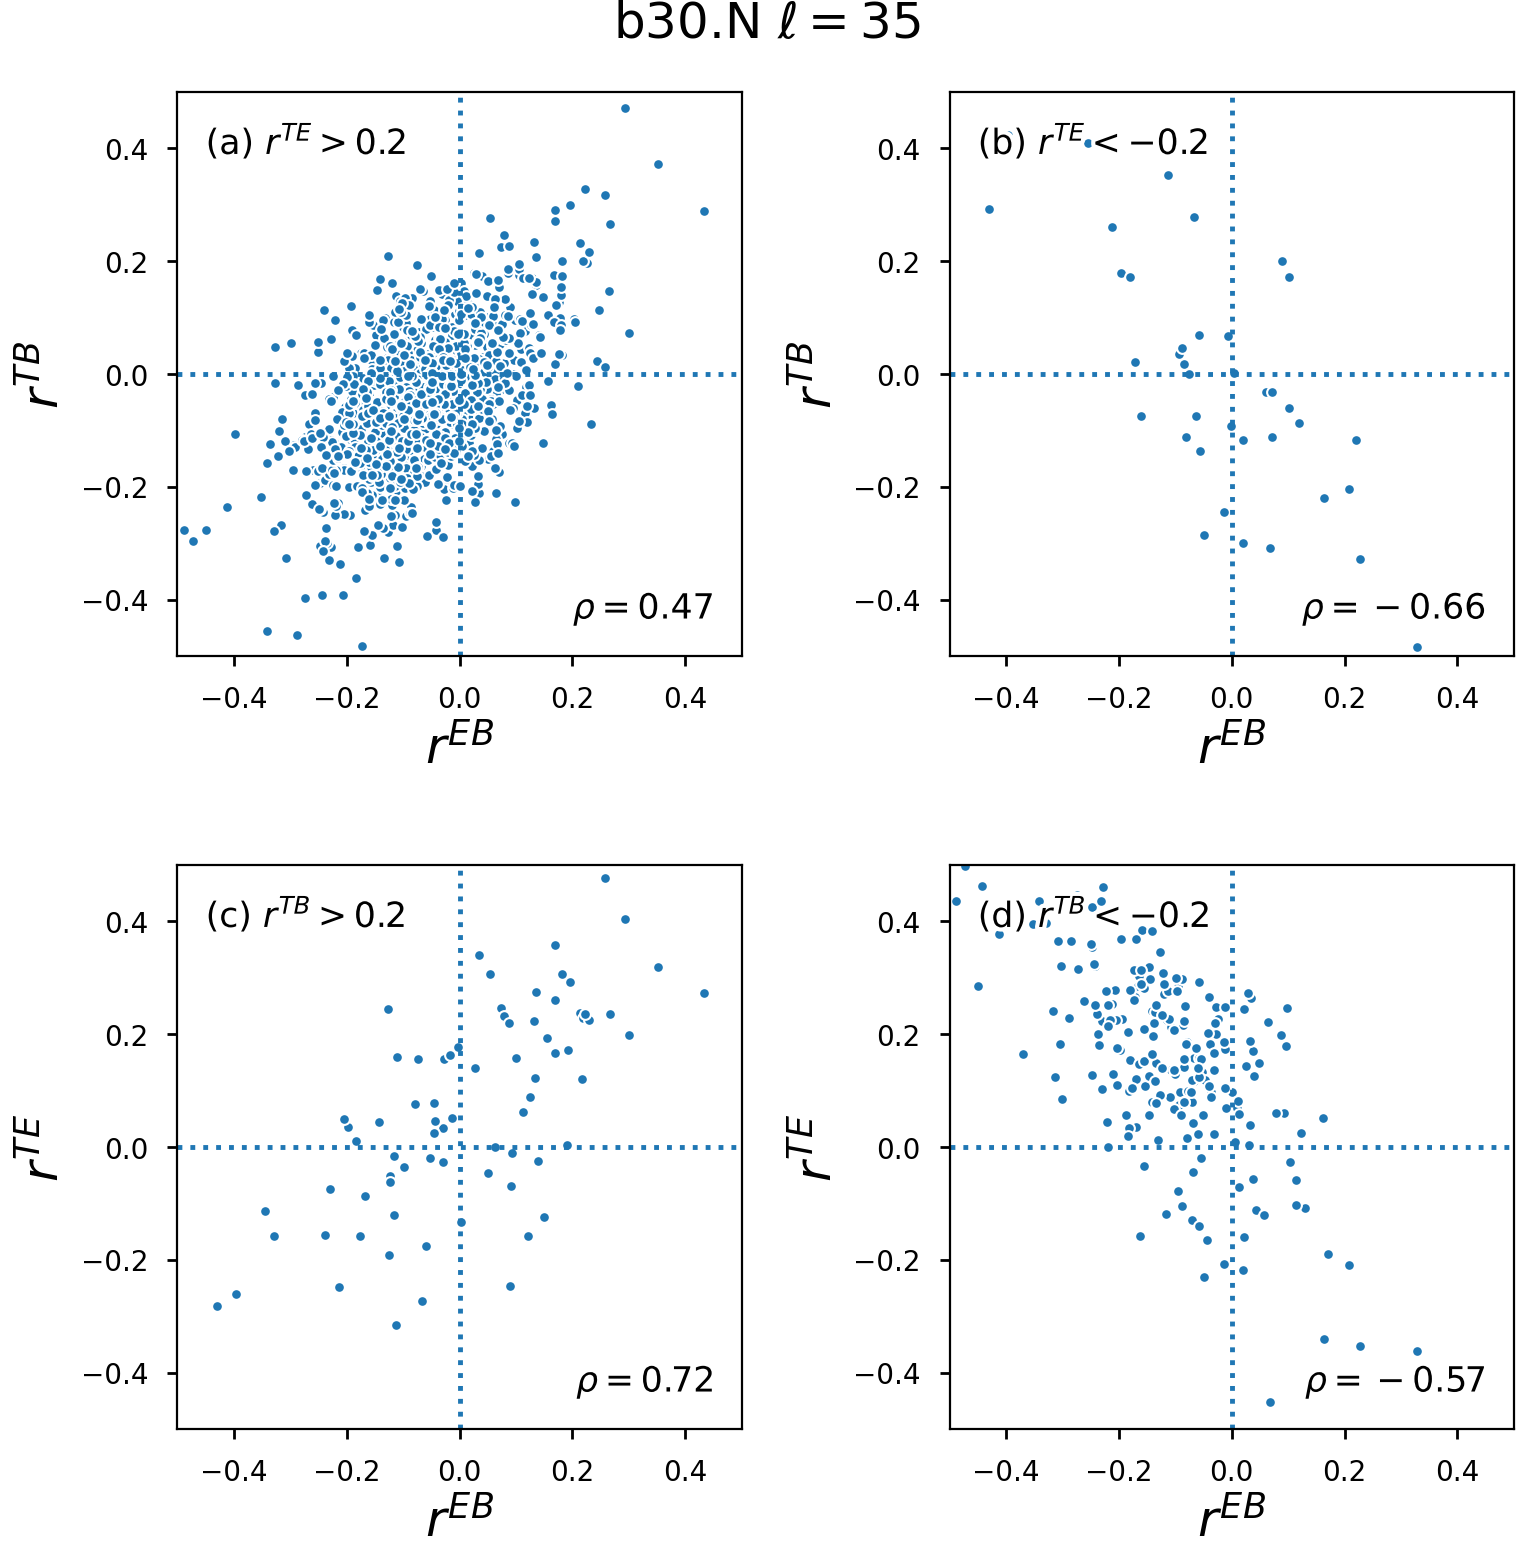

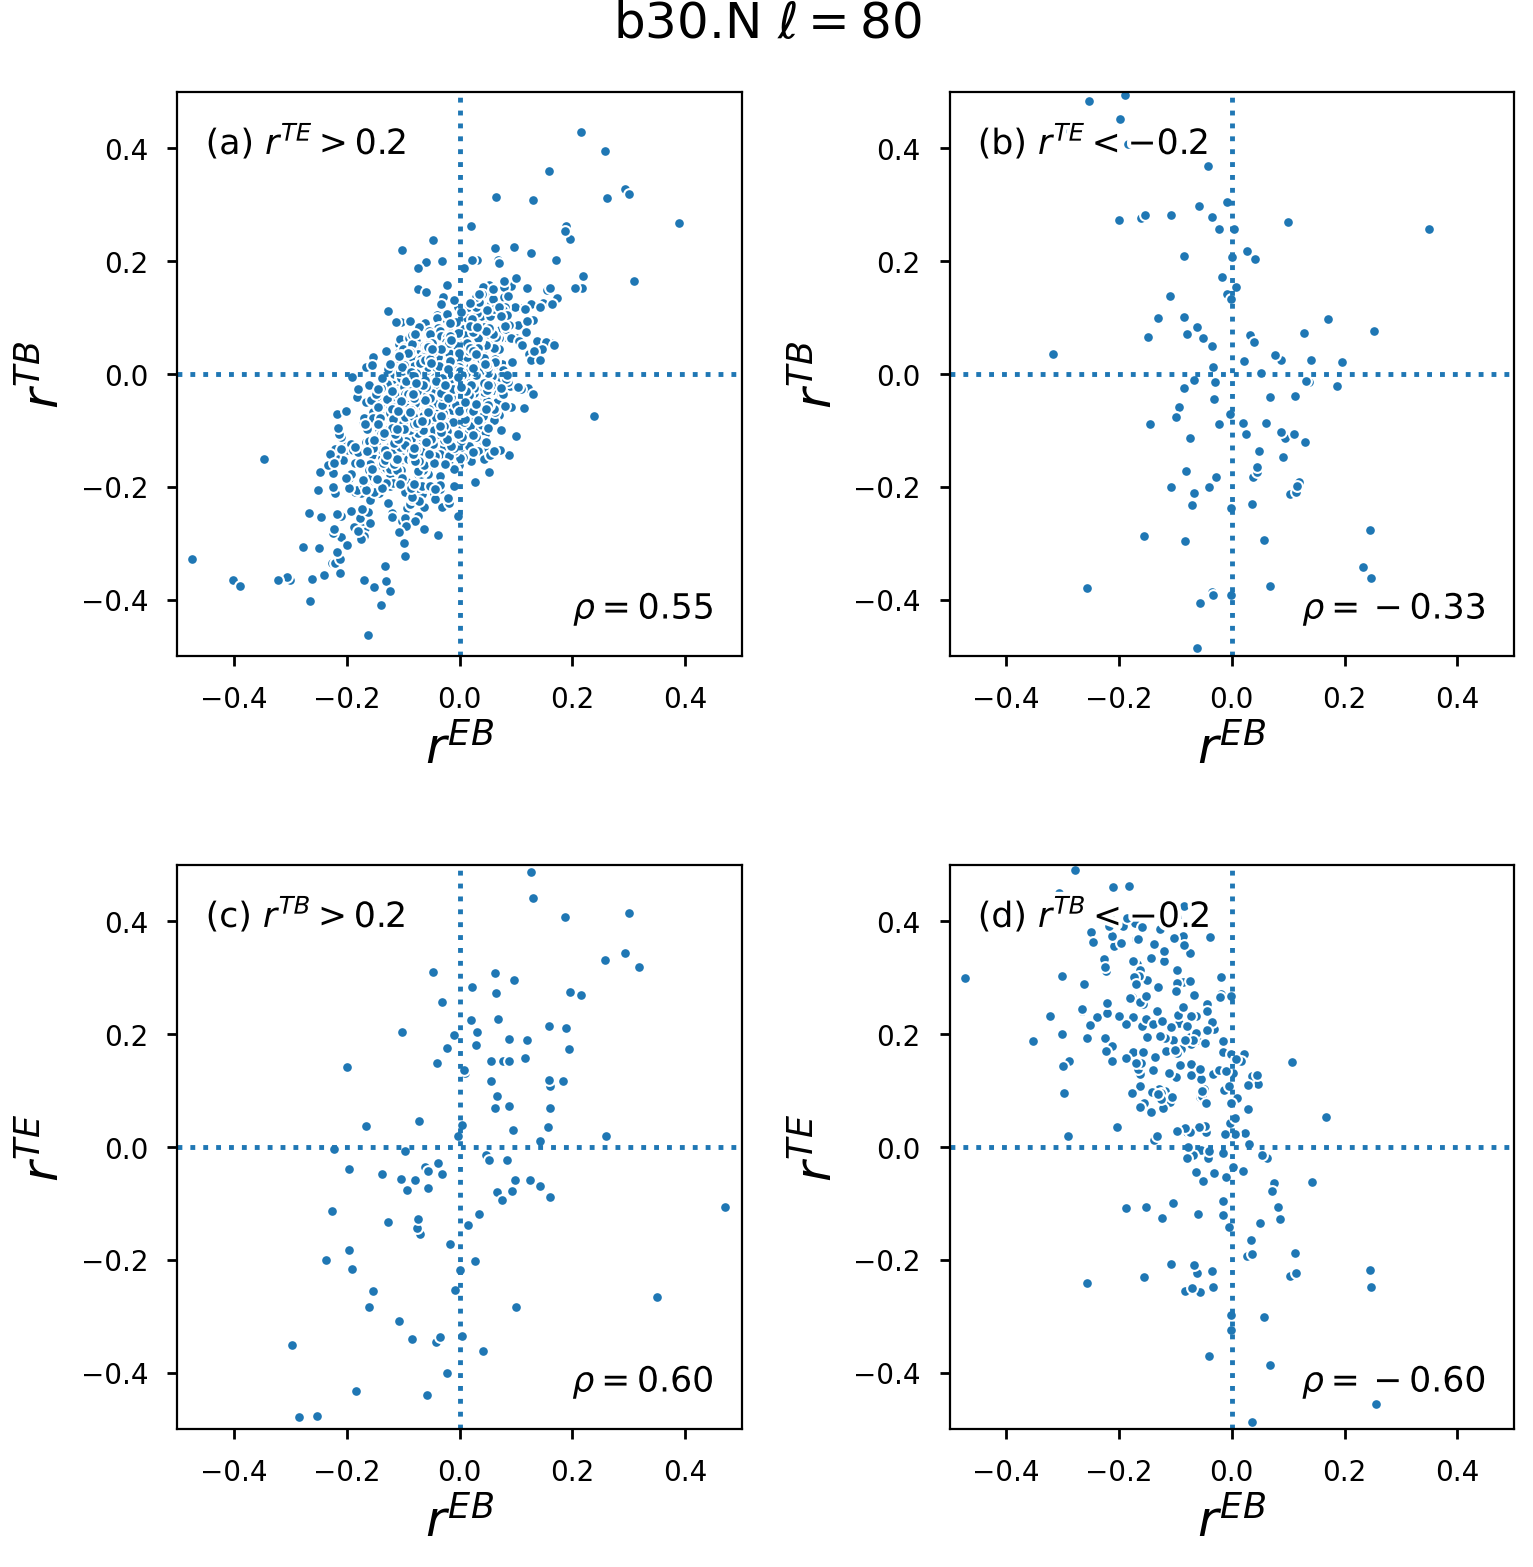

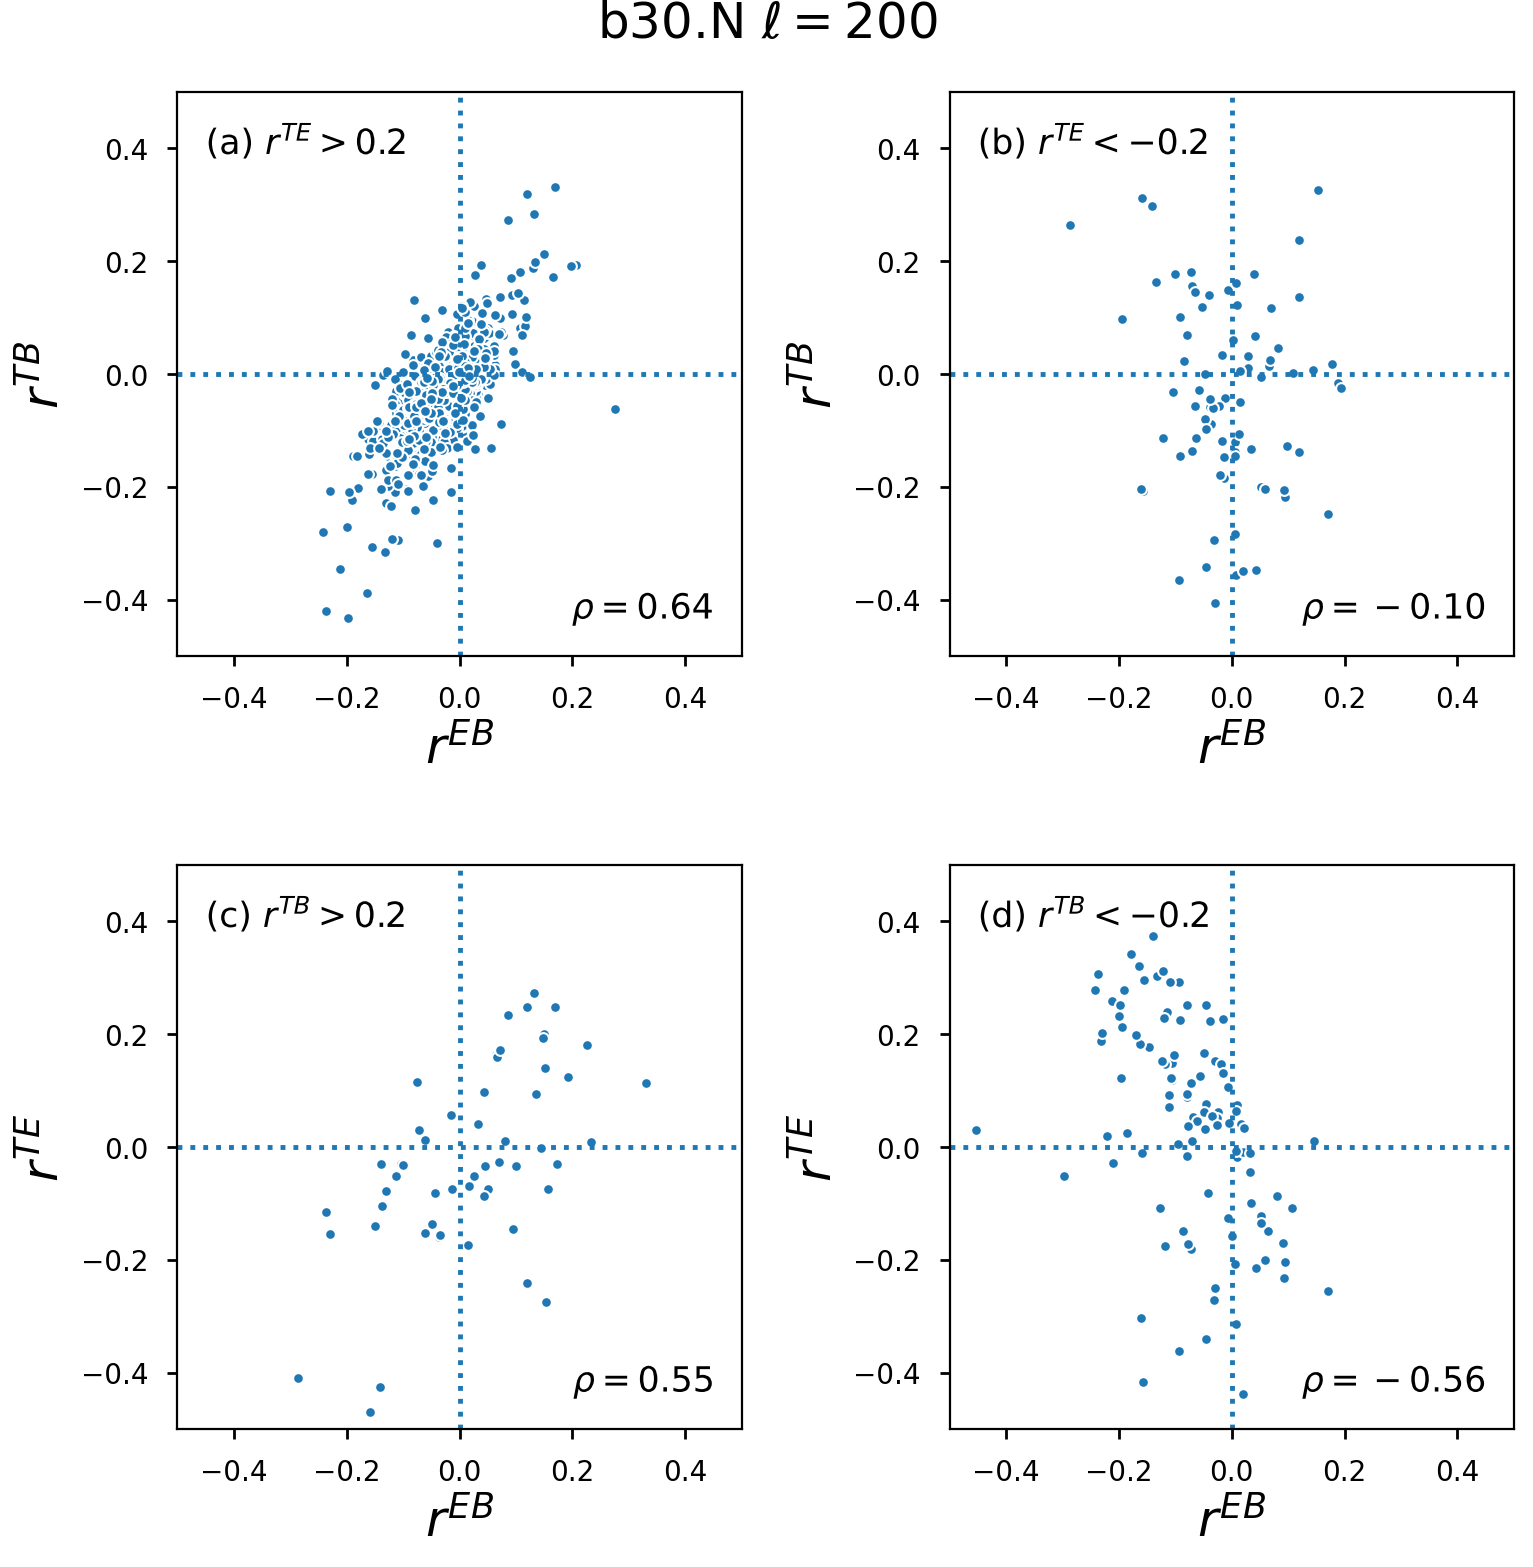

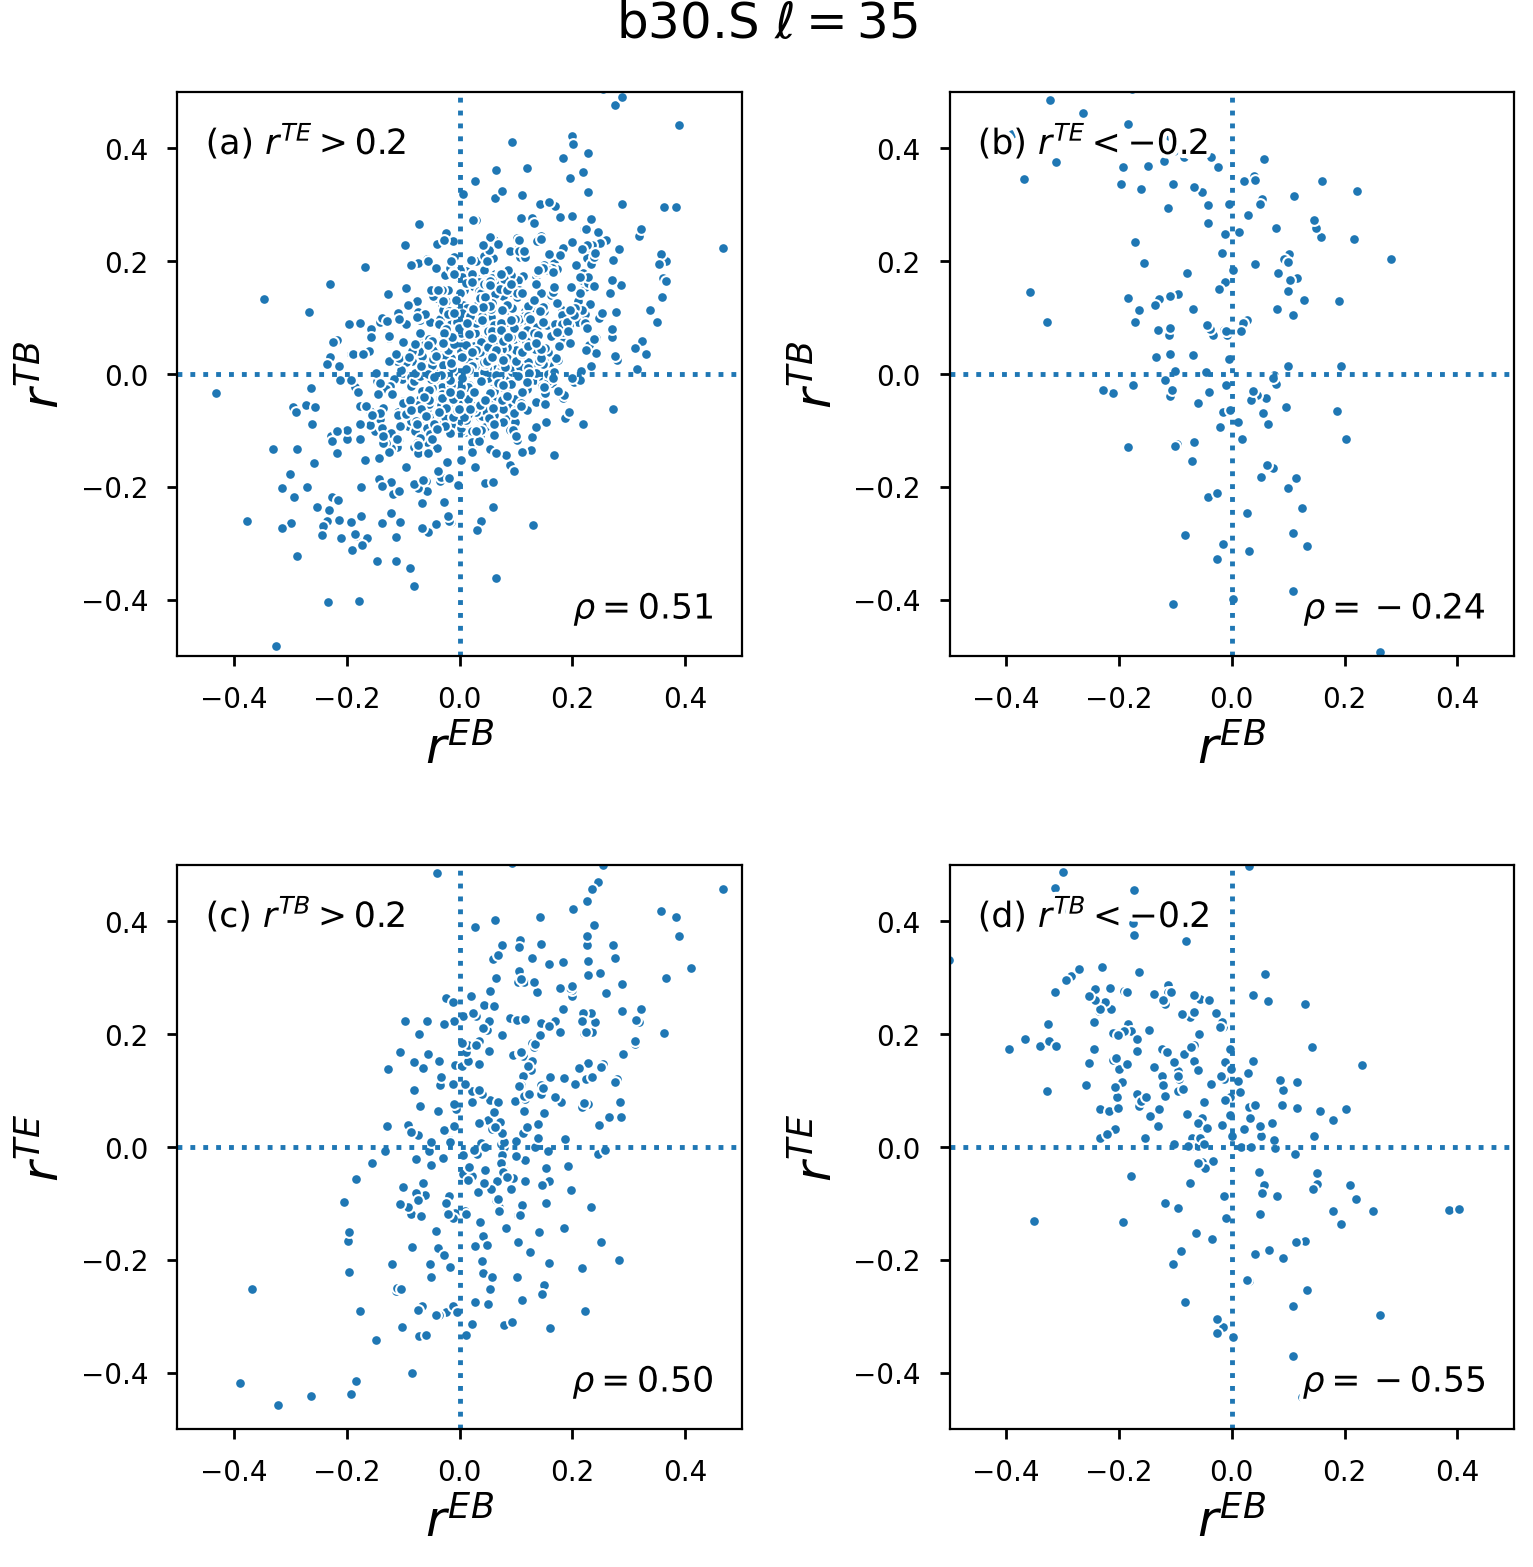

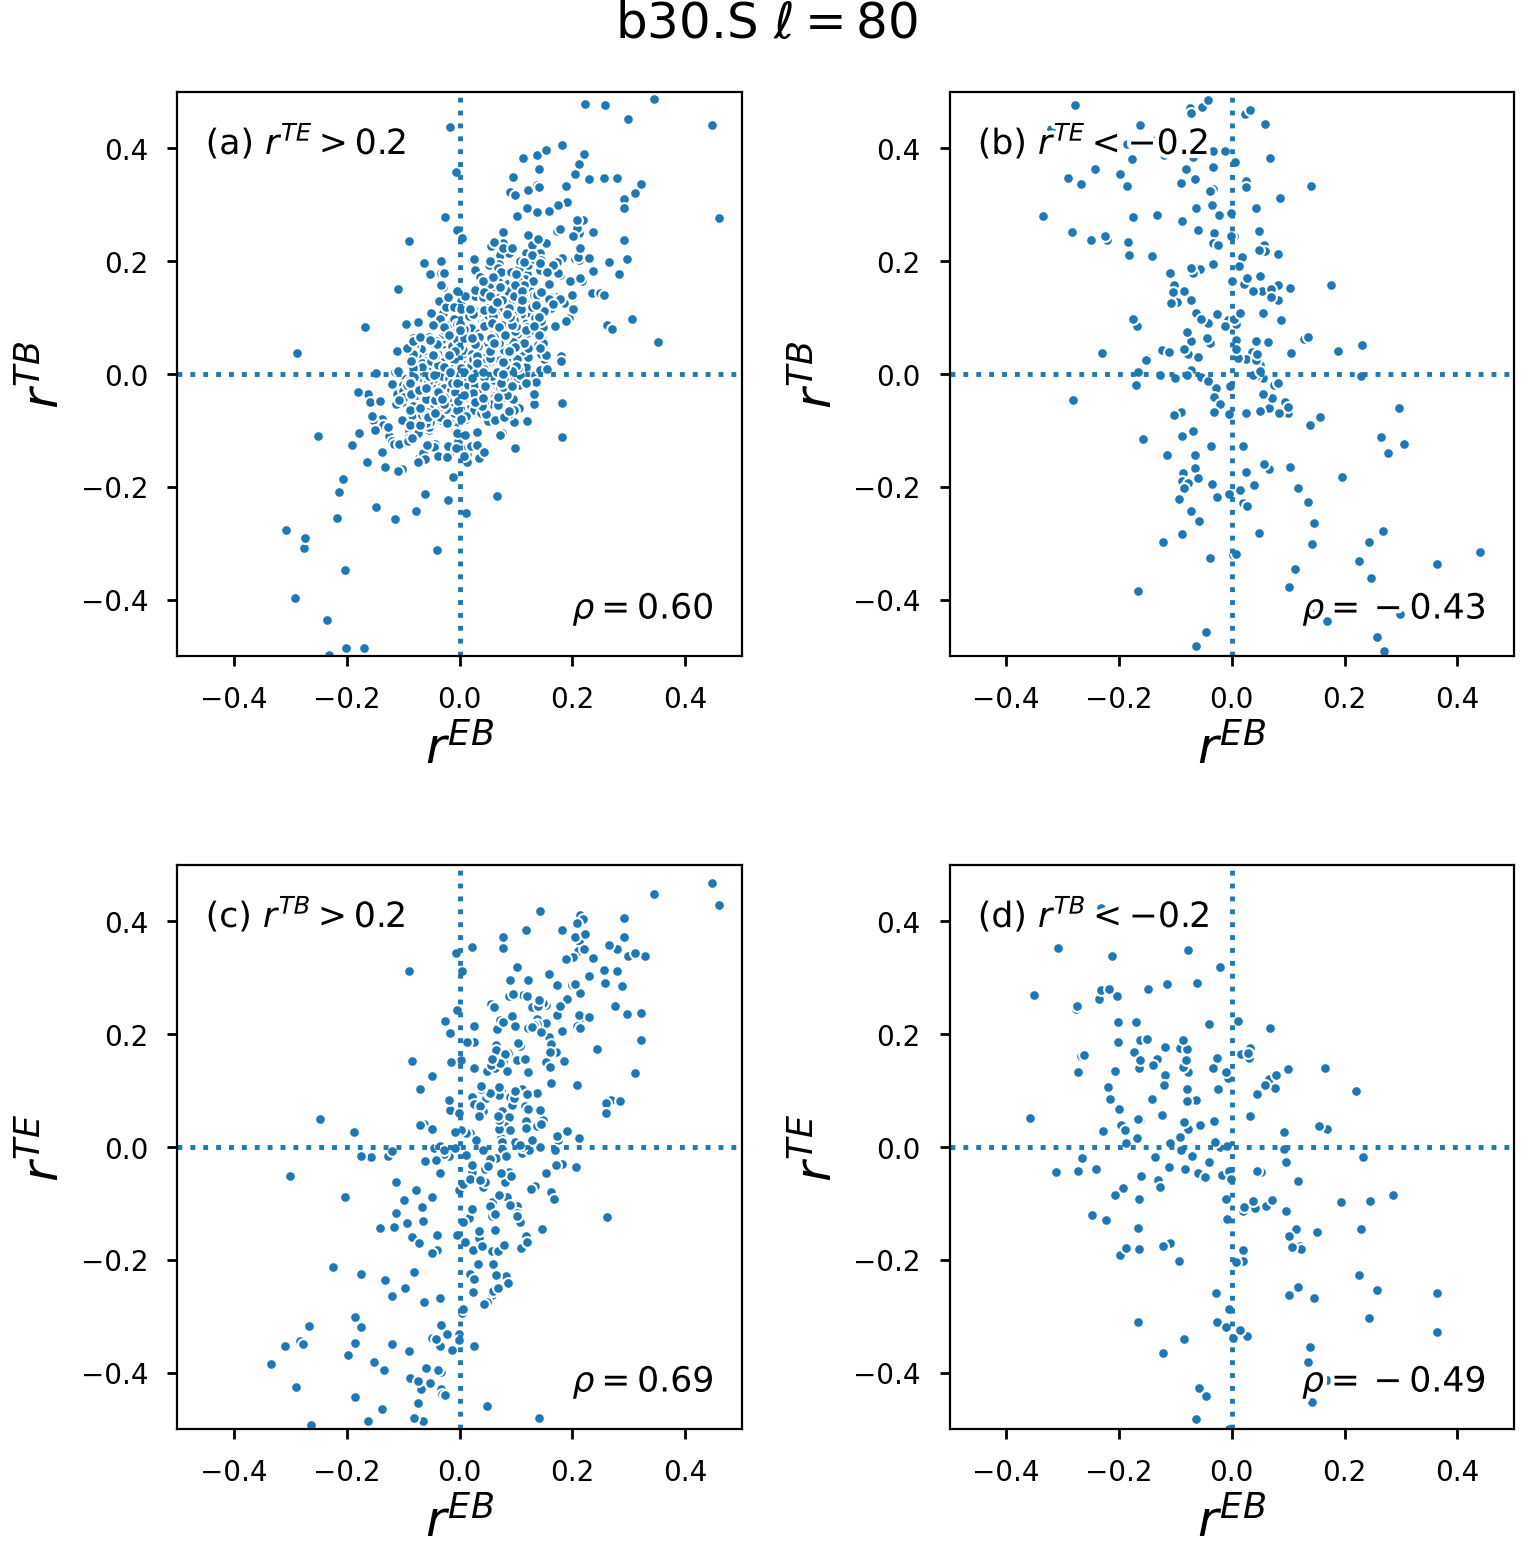

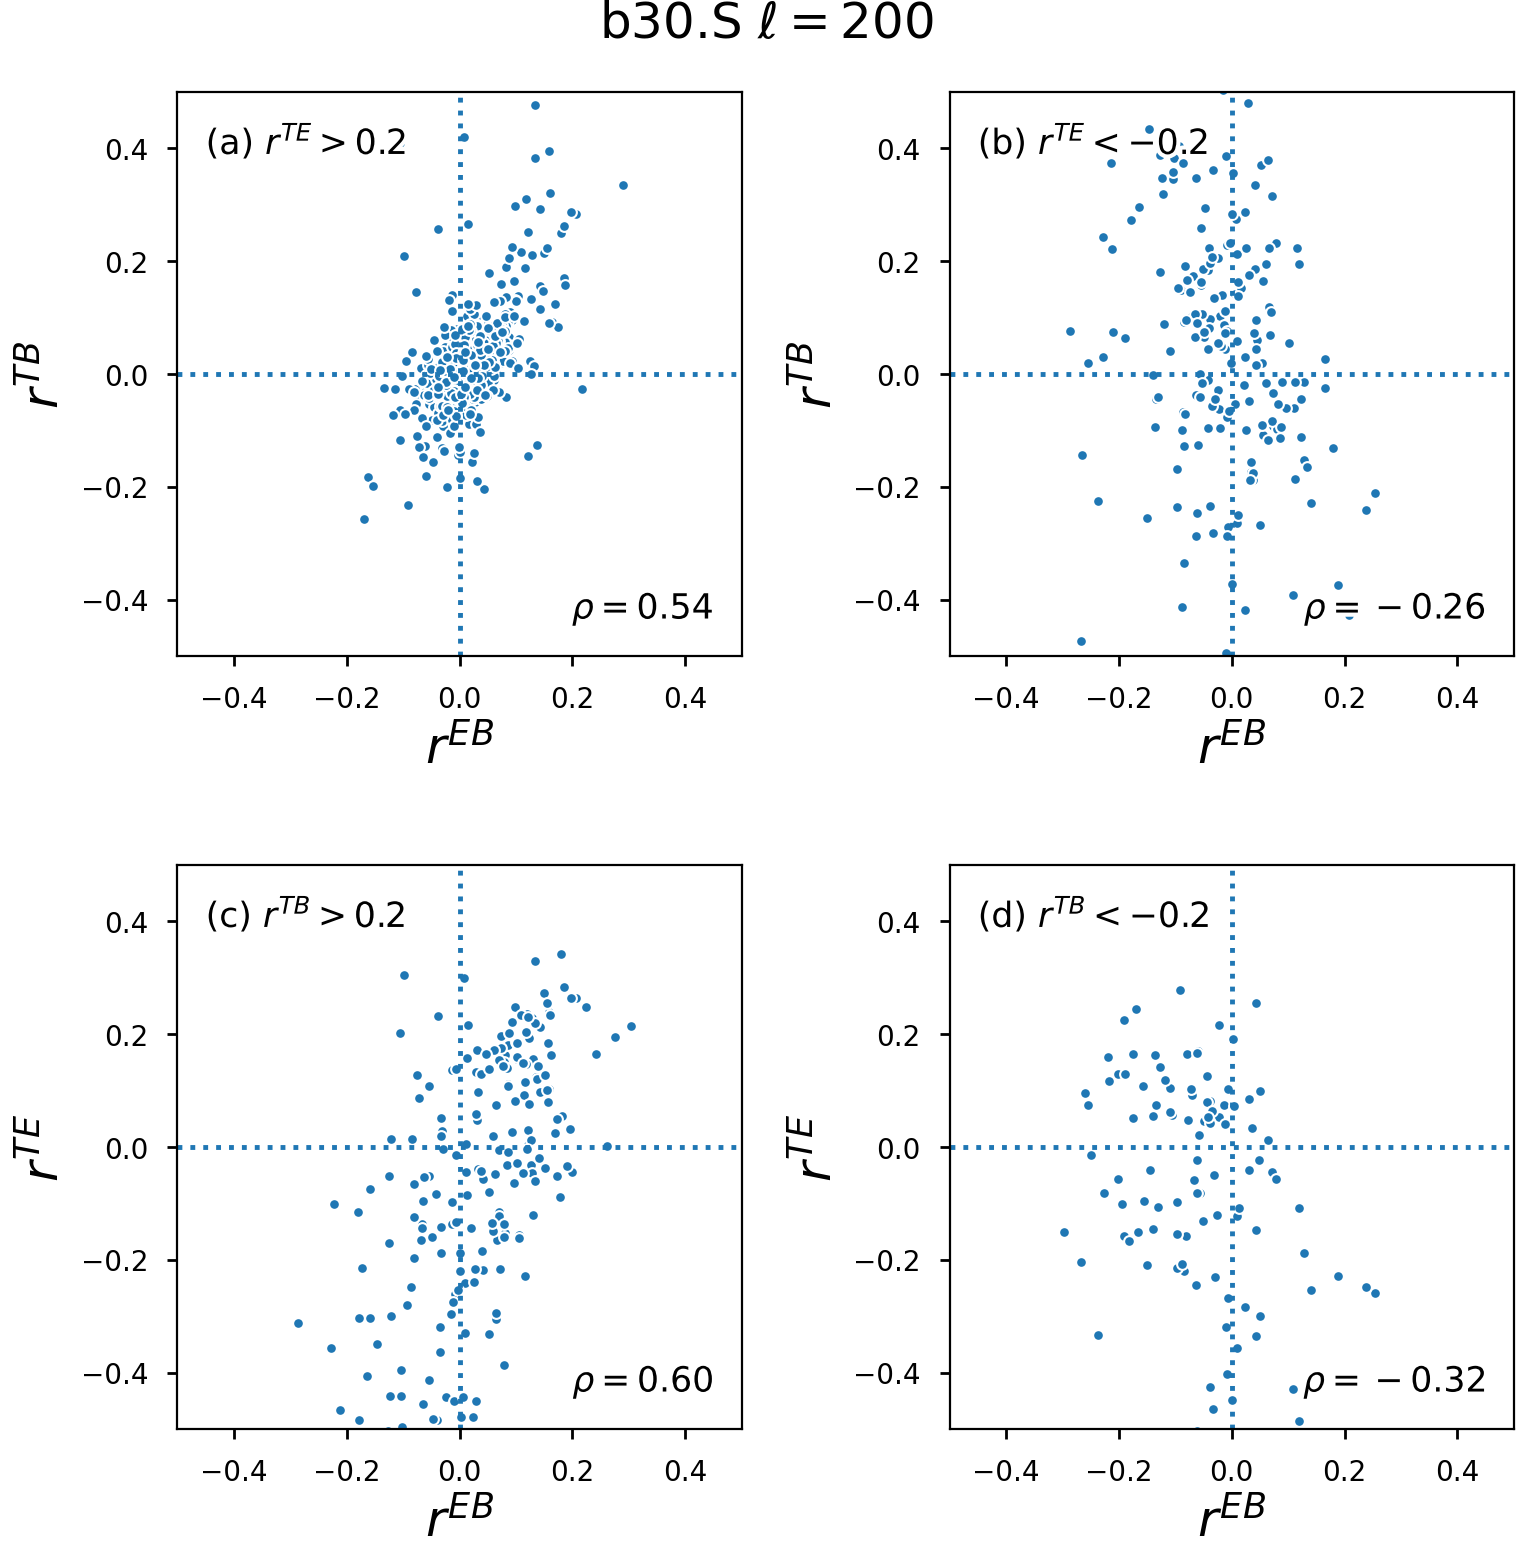

In [16]:
from scipy import stats

with plt.style.context(['seaborn-notebook',{'figure.dpi':200,'font.size':18,'axes.labelsize':'medium'}],after_reset=True):
    for dflist,bcut in zip([Ndflist,Sdflist],['b30.N','b30.S']):
        for df,lc in zip(dflist,['l35','l80','l200']):
            dfpTE = df.where(df.rTE>0.2)[['rTB','rEB']]
            dfnTE = df.where(df.rTE<-0.2)[['rTB','rEB']]
            dfpTB = df.where(df.rTB>0.2)[['rTE','rEB']]
            dfnTB = df.where(df.rTB<-0.2)[['rTE','rEB']]
            fig,axes = plt.subplots(2,2,figsize=(8,8))
            for ax,x,y,df_,lab in zip(axes.flat,
                                     ['rEB','rEB','rEB','rEB'],
                                     ['rTB','rTB','rTE','rTE'],
                                     [dfpTE,dfnTE,dfpTB,dfnTB],
                                      ['(a) $r^{TE}>0.2$','(b) $r^{TE}<-0.2$','(c) $r^{TB}>0.2$','(d) $r^{TB}<-0.2$']
                                     ):
                plt.sca(ax)
                sns.scatterplot(x,y,data=df_, s=15)
        #         sns.regplot(x,y,data=df_,scatter_kws=dict(alpha=0.5, s=15))
                slope, intercept, r_value, p_value, std_err = stats.linregress(df_[x].dropna(),df_[y].dropna())
                print(x,y,slope,intercept)
                slope, intercept, r_value, p_value, std_err = stats.linregress(df_[y].dropna(),df_[x].dropna())
                print(y,x,slope,intercept)

                corr = df_.corr(method=corr_method)

                plt.annotate(lab,(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='x-small',
                             path_effects=[withStroke(foreground='w',linewidth=3)])
                plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.05),
                             ha='right',va='bottom',xycoords='axes fraction',fontsize='x-small',
                             path_effects=[withStroke(foreground='w',linewidth=3)])
                plt.axhline(0,ls=':')
                plt.axvline(0,ls=':')
                plt.xlim(-0.5,0.5)
                plt.ylim(-0.5,0.5)
        #         plt.plot([-0.3,0.3],[-0.6,0.6])
        #         plt.plot([-0.3,0.3],[0.6,-0.6])
                plt.xlabel(labels_dict[x])
                plt.ylabel(labels_dict[y])
                ax.set_aspect('equal')
            plt.tight_layout()
            plt.annotate(r'{} $\ell=${}'.format(bcut,lc[1:]),(.5,1),xycoords='figure fraction',ha='center',va='top')
            fig.savefig('../figures/correlation_{}_{}_{}.png'.format(corr_method,bcut,lc),bbox_inches='tight',dpi=200)